## Notebook to code up method of moments framework 

Here, I will use the method of moments framework used to track the trajectory of the site frequency spectrum through time given drift and selection from [Jouganous et. al. 2017](https://www.genetics.org/content/206/3/1549). Mostly, I will just use equations to start from a certain generation $t$ back in time and then iterate until generation 0. Then I will store this SFS as a data entry for allele age $t$ and certain selection coefficient $s$. This process will be repeated for each value of $\{1,\ldots,gen,\ldots,12000\}$ generations. 

These vectors need to be summed to marginalize over *all* generations $a$, to give $P(X, a | s)$.

First, need to get a handle on what $\Phi_n^k(i)$ really is - can just be represented as *np.array*

$\phi_n^k(i)$ is the expected number of sites where the alternate allele is observed exactly $i$ times in a sample of size $n$ at generation $k$. 

In [2]:
# numerics + rv stuff
from numba import jit
import numpy as np
import scipy as sp
from scipy.stats.distributions import chi2
from scipy.sparse import coo_matrix
from scipy.sparse import linalg
from numpy.random import default_rng
import moments
# import dadi 
# import Selection
# plotting + misc tools
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import itertools as it
from copy import deepcopy
import matplotlib.colors as colors
import seaborn
from matplotlib import cm 
from mom_functions import *

# rng setup
rng = default_rng(100496)

# change matplotlib fonts
plt.rcParams["font.family"] = "Arial"
plt.rcParams["font.sans-serif"] = "Arial"
plt.rcParams["figure.figsize"] = [5, 3.5]
plt.rcParams["figure.dpi"] = 110
plt.rcParams["axes.axisbelow"] = True
plt.rcParams.update({"figure.facecolor": "white"})

# set numpy print option to a more readable format for floats
np.set_printoptions(formatter={'float': lambda x: "{0:0.3f}".format(x)})

%load_ext autoreload
%autoreload 2

In [2]:
N = 10000
s = -10/N # 25/N -> gamma2 = 50 - strong selection
mu = 1.25e-8 # human mutation rate
n = 2000 # 2 * # of inds sampled, diploid

# start in generation 10 so generation 11 has all zeros (going back in time)
tot_gen = 10000
time_steps = np.linspace(0, tot_gen-1, 100, dtype=int)

mom = np.zeros((tot_gen+1,n+1))
momnp1 = np.zeros(n+1)
momkp1 = np.zeros((tot_gen+1,n+1))

# double precaution - creating a mask
mk = [False] + [True]*(n-1) + [False]

iter = np.arange(1,n)
iterm1p1 = np.arange(2,n-1)

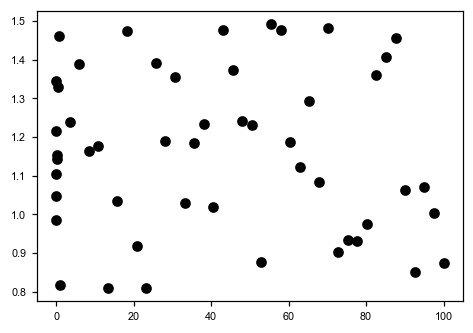

In [ ]:
plt.plot(np.append(np.linspace(0.0, 1.0, num=10)**np.exp(1),np.linspace(100,1,40,endpoint=False)[::-1]),np.random.uniform(0.8,1.5,50),'ko'); plt.semilogx()
# np.geomspace(100,1,20,endpoint=False)[::-1]

In [3]:
## borrowed directly from https://bitbucket.org/simongravel/moments/src/main/moments/Jackknife.pyx
def python2round(f):
    if round(f + 1) - round(f) != 1:
        return f + abs(f) / f * 0.5
    return round(f)

# The choice i' in n samples that best approximates the frequency of i/(n + 1) is i*n / (n + 1)
def index_bis(i, n):
    return int(min(max(python2round(i * n / float(n+1)), 2), n-2))

In [4]:
# code borrowed from https://bitbucket.org/simongravel/moments/src/main/moments/Jackknife.pyx  
def calcJK13(n):
    J = np.zeros((n,n-1))
    for i in range(n):
        ibis = index_bis(i + 1, n) - 1
        J[i, ibis] = -(1.+n) * ((2.+i)*(2.+n)*(-6.-n+(i+1.)*(3.+n))-2.*(4.+n)*(-1.+(i+1.)*(2.+n))*(ibis+1.)+(12.+7.*n+n**2)*(ibis+1.)**2) / (2.+n) / (3.+n) / (4.+n)
        J[i, ibis - 1] = (1.+n) * (4.+(1.+i)**2*(6.+5.*n+n**2)-(i+1.)*(14.+9.*n+n**2)-(4.+n)*(-5.-n+2.*(i+1.)*(2.+n))*(ibis+1.)+(12.+7.*n+n**2)*(ibis+1.)**2) / (2.+n) / (3.+n) / (4.+n) / 2.
        J[i, ibis + 1] = (1.+n) * ((2.+i)*(2.+n)*(-2.+(i+1.)*(3.+n))-(4.+n)*(1.+n+2.*(i+1.)*(2.+n))*(ibis+1.)+(12.+7.*n+n**2)*(ibis+1.)**2) / (2.+n) / (3.+n) / (4.+n) / 2.
    return J

In [ ]:
## testbed for a single realization of gen = t
mom[tot_gen,1] = n*mu # singleton input

J = calcJK13(n)

# going from generation 9 to 0
for gen in np.arange(tot_gen)[::-1]:
    momkp1[gen,iterm1p1] = 0.25/N * (mom[gen+1,iterm1p1-1] * (iterm1p1-1)*(n-iterm1p1+1) + mom[gen+1,iterm1p1+1] * (iterm1p1+1)*(n-iterm1p1-1) - mom[gen+1,iterm1p1] * 2*iterm1p1*(n-iterm1p1))

    momkp1[gen,1] = 0.25/N * ((n-2) * 2 * mom[gen+1,2] - 2 * (n-1) * mom[gen+1,1])
    momkp1[gen,n-1] = 0.25/N * ((n-2) * 2 * mom[gen+1,n-2] - 2 * (n-1) * mom[gen+1,n-1])

    # notice the difference in indexing for LHS
    # momnp1[np.arange(1,n+1)] = (jk13[:,0] * mom[gen+1,np.array(ibis)-1] - jk13[:,1] * mom[gen+1,np.array(ibis)] + jk13[:,2] * mom[gen+1,np.array(ibis)+1])
    momnp1[np.arange(1,n+1)] = (J @ mom[gen+1,iter])

    momkp1[gen,iter] += mom[gen+1,iter] + 0.5 * s/(n+1) * (iter * (n+1-iter) * momnp1[iter] - (n-iter) * (iter+1) * momnp1[iter+1])

    mom[gen,] = deepcopy(momkp1[gen,])

mom2 = deepcopy(mom)

In [ ]:
## code to run APR's moments and compare with output from above
# initialize the spectrum, with 1 in singleton bin
fs = moments.Spectrum(np.zeros(2*n + 1))
fs[1] = n*1
# simulate a generations
T = tot_gen / 2 / N
# set relative size to 1, theta to 0 to forbid new mutations
fs.integrate([1], T, gamma=s*2*N, h=0.5, theta=0, adapt_dt=True, dt_fac=0.005)

In [ ]:
## testbed for a single realization of gen = t & the Crank-Nicolson method
mom[100,1] = n*1 # singleton input

dt = 1

D = 0.25/N * calcD(n+1)
J = calcJK13(n+1)
S = 0.5 * s * calcS(n+1, J)

# if N is same across all gens then only have to do this once
slv = linalg.factorized(sp.sparse.identity(S.shape[0], dtype="float", format="csc") - dt / 2.0 * (D + S))
Q = sp.sparse.identity(S.shape[0], dtype="float", format="csc") + dt / 2.0 * (D + S)

# going from generation 9 to 0
for gen in np.arange(100)[::-1]:

    # momkp1[gen,iter] = mom[gen+1,iter] + ((D[iter,] + S[iter,]) @ mom[gen+1,])
    momkp1[gen,iter] = mom[gen+1,iter] + slv(Q.dot(mom[gen+1,iter]))
    momkp1[gen,0] = momkp1[gen,n] = 0.0

    mom[gen,] = deepcopy(momkp1[gen,])

In [5]:
def calcD(d):
    data = []
    row = []
    col = []
    # loop over the fs elements:
    for i in range(d):
        if i > 1:
            data.append((i-1) * (d-i))
            row.append(i)
            col.append(i - 1)
        if i < d - 2:
            data.append((i+1) * (d-i-2))
            col.append(i + 1)
            row.append(i)
        if i > 0 and i < d - 1:
            data.append(-2 * i * (d-i-1))
            row.append(i)
            col.append(i)

    return coo_matrix((data, (row, col)), shape=(d, d), dtype='float').tocsc()

In [6]:
def calcS(d, ljk):
    # Computes the jackknife-transformed selection matrix 1
    # for the addition of a single sample
    # arrays for the creation of the sparse (coo) matrix
    # data will have matrix entry, row + column have coordinates
    data = []
    row = []
    col = []
    # loop over the fs elements:
    for i in range(d):
        i_bis = index_bis(i, d - 1) # This picks the second jackknife index 
        i_ter = index_bis(i + 1, d - 1) # This picks the third jackknife index
        # coefficients of the selection matrix
        g1 = i * (d-i) / np.float64(d)
        g2 = -(i+1) * (d-1-i) / np.float64(d)

        if i < d - 1 and i > 0: # First deal with non-fixed variants
            data += [g1 * ljk[i - 1, i_bis - 1], g1 * ljk[i - 1, i_bis - 2],
                    g1 * ljk[i - 1, i_bis], g2 * ljk[i, i_ter - 1],
                    g2 * ljk[i, i_ter - 2], g2 * ljk[i, i_ter]]
            row += 6 * [i]
            col += [i_bis, i_bis - 1, i_bis + 1,
                    i_ter, i_ter - 1, i_ter + 1]
        
        elif i == 0: # g1=0
            data += [g2 * ljk[i, i_ter - 1],
                     g2 * ljk[i, i_ter - 2], g2 * ljk[i, i_ter]]
            row += 3 * [i]
            col += [i_ter, i_ter - 1, i_ter + 1]
        
        elif i == d - 1: # g2=0
            data += [g1 * ljk[i - 1, i_bis - 1], g1 * ljk[i - 1, i_bis - 2],
                     g1 * ljk[i - 1, i_bis]]
            row += 3 * [i]
            col += [i_bis, i_bis - 1, i_bis + 1]

    return coo_matrix((data, (row, col)), shape=(d, d), dtype='float').tocsc()

In [ ]:
## packaging into a function for easy manipulation - iteration implementation 
# input: a (number of gens), n (number of samples), s, N (pop size)
# output: mom (number of sites)
def run_mom_iterate(a, n, s, N, mu, misc):
    mom = np.zeros((a+1,n+1))
    # momnp1 = np.zeros(n+1)
    momkp1 = np.zeros(n+1)

    D = 0.25/N * calcD(n+1)
    J = calcJK13(n)
    S = 0.5 * s * calcS(n+1, J)

    # if N is same across all gens then only have to do this once
    slv = linalg.factorized(sp.sparse.identity(S.shape[0], dtype="float", format="csc") - 0.5 * (D + S))
    Q = sp.sparse.identity(S.shape[0], dtype="float", format="csc") + 0.5 * (D + S)

    mom[a,1] = 1 # singleton input

    # going from generation 9 to 0
    for gen in np.arange(a)[::-1]:
        momkp1 = slv(Q.dot(mom[gen+1,]))
        momkp1[0] = momkp1[n] = 0.0

        mom[gen,] = deepcopy(momkp1)

    return mom[:-1,:]           

In [ ]:
@jit(nopython=True)
def run_mom_iterate_changing(n, s, Nc, mu, misc):
    mom = np.zeros((len(Nc)+1,n+1))
    # momnp1 = np.zeros(n+1)
    momkp1 = np.zeros(n+1)

    changepoints = len(Nc) - np.concatenate((np.array([0]),np.where(Nc[:-1] != Nc[1:])[0]+1),axis=0)
    changepoints = np.append(changepoints, 0)

    mom[len(Nc),1] = 1 # singleton input
    
    # only need to do this once - no dependence on N
    J = calcJK13(n)
    S = 0.5 * s * calcS(n+1, J)

    for i in range(len(changepoints)-1):
        D = 0.25/Nc[len(Nc)-changepoints[i]] * calcD(n+1)

        slv = linalg.factorized(sp.sparse.identity(S.shape[0], dtype="float", format="csc") - 0.5 * (D + S))
        Q = sp.sparse.identity(S.shape[0], dtype="float", format="csc") + 0.5 * (D + S)

        for gen in np.arange(changepoints[i+1],changepoints[i])[::-1]:
            momkp1 = slv(Q.dot(mom[gen+1,]))
            momkp1[0] = momkp1[n] = 0.0

            mom[gen,] = deepcopy(momkp1)

    return mom[:-1,:]           

In [ ]:
## starting from the past to the present (Nc[-1] is current generation)
# Nc = np.concatenate((np.repeat(20000,1000),np.repeat(2000,2000)))
# changepoints = len(Nc) - np.concatenate((np.array([0]),np.where(Nc[:-1] != Nc[1:])[0]+1),axis=0)
# changepoints = np.append(changepoints, 0)
# mom_outc = run_mom_iterate_changing(1000, -0.000125, Nc/2, 1.25e-8, None)
# plt.imshow(mom_outc[000:2100,:]/np.sum(mom_outc[000:2100]),aspect='auto',norm=colors.LogNorm()); plt.colorbar(); plt.show()
# plt.imshow(up_xa_s[gamma2[-20]],aspect='auto',norm=colors.LogNorm(vmax=1e-3,vmin=1e-10)); plt.colorbar(); plt.show()
plt.imshow(up_xa_s[-100.],aspect='auto',norm=colors.LogNorm(vmax=1e-3,vmin=1e-10)); plt.colorbar(); plt.show()
# plt.plot(mom_outc[-100,:]); plt.plot(mom_outc[-2000,:]); plt.loglog(); plt.ylim((1e-10,1))

In [ ]:
gamma2

In [ ]:
# fs = run_mom_integrate(4000, 1000, 0.5*gamma[0]/N, N, mu, misc = {'dt_fac':0.02, 'adapt_dt':False})
# plt.imshow(fs[:,:],aspect='auto',norm=colors.LogNorm(vmax=10e-7,vmin=10e-30)); plt.colorbar(); plt.show()
# fs2 = run_mom_integrate2(4000, 200, 0.5*gamma[0]/N, N, mu, misc = {'dt_fac':0.02, 'adapt_dt':False})
# plt.imshow(fs2[:,:],aspect='auto',norm=colors.LogNorm(vmax=10e-7,vmin=10e-30)); plt.colorbar(); plt.show()
# mom = run_mom_iterate(8000, 2000, 0.5*gamma[10]/N, N, mu, np.nan)
# plt.imshow(mom[:,:],aspect='auto',norm=colors.LogNorm(vmax=10e-7,vmin=10e-30)); plt.colorbar(); plt.show()
# fs.shape, mom.shape
# plt.scatter(np.ravel(mom[:,1:-1]), np.ravel(fs[:,1:-1]), color='grey', alpha=0.75, s=5); plt.loglog()
# plt.axline((0,0),(1,1),color='coral',ls='--', linewidth=0.6); plt.xlabel('iterative framework'); plt.ylabel('integrative framework'); plt.title('γ = {}'.format(-100.))

In [ ]:
## function where each generation was integrated to separately
def run_mom_integrate(a, n, s, N, mu, misc):
    fsmat = np.zeros((a,n+1))
    for idt, dt in enumerate(np.linspace(0.5/N,0.5*a/N,a)[::-1]):
        fs = moments.Spectrum(np.zeros(n + 1))
        fs[1] = 1
        fs.integrate([1], dt, gamma=2*s*N, h=0.5, theta=0, dt_fac=misc['dt_fac'], adapt_dt=misc['adapt_dt'])
        fsmat[idt,:] = n*mu*fs
    return fsmat

## function where each generation is only integrated from previous generation
def run_mom_integrate2(a, n, s, N, mu, misc):
    fsmat = np.zeros((a,n+1))
    dt = 0.5/N
    fs = moments.Spectrum(fsmat[-1,:])
    fs[1] = 1
    fs.integrate([1], dt, gamma=2*s*N, h=0.5, theta=0)
    fsmat[-1,:] = fs
    for idt in np.arange(0,a-1)[::-1]:
        # fs = moments.Spectrum(fsmat[idt+1,:])
        fs.integrate([1], dt, gamma=2*s*N, h=0.5, theta=0, dt_fac=misc['dt_fac'], adapt_dt=misc['adapt_dt'])
        fsmat[idt,:] = fs
    return n*mu*fsmat

In [ ]:
# fs.integrate([1],2,gamma=-10,theta=1)
# fs1 = moments.Spectrum(np.zeros(n+1))
# fs1[1]=1
# fs1.integrate([1],2,gamma=-1,theta=1)

In [ ]:
# gamma2 = np.hstack((np.logspace(1,-2,10),0.0,-np.logspace(-2,1,10)))

In [ ]:
## creating a database of P(X, a | s) with dicts for different s values
# import io
# up_xa_s = h5py.File(io.BytesIO(), 'w')
# del up_xa_s
gamma2 = -np.logspace(-.5,2.5,25,) 
# up_xa_s = dict.fromkeys(gamma2)
## use different lengths of time for each gamma (high gamma - small limits)
## go up to 5 orders of magnitude below start (i.e., E[# seg sites] < 1e-11)
# limal = np.concatenate((np.linspace(7500,85000,20,dtype=int),np.repeat(85000,30)))
# limal = np.linspace(140000,10000,25,dtype='int')
# for ig, g in enumerate(gamma2):
    # unscaled probability - almost likelihood
    # up_xa_s[g] = run_mom_iterate(limal[ig], 2000, 0.5*g/N, N, 1.25e-8, misc = {'dt_fac':0.02, 'adapt_dt':True})
    # can project down to any sample size using moments.Spectrum(p_xa_s[g][-1,:]).project([20])*120/20

In [ ]:
# up_xa_s_neut = run_mom_iterate(100000, 2000, 0, N, 1.25e-8, misc = {'dt_fac':0.02, 'adapt_dt':True})
cutoff = 2
up_xa_s_neut[:,np.arange(cutoff,n-cutoff+1)] = up_xa_s_neut[:,np.arange(cutoff,n-cutoff+1)]/np.sum(up_xa_s_neut[:,np.arange(cutoff,n-cutoff+1)])
p_xa_s_neut = np.sum(up_xa_s_neut, axis=0)

In [ ]:
testup_xa_s = {}
testup_xa_s[gamma[6]] = run_mom_integrate(80000, 2000, 0.5*g/N, N, mu, misc = {'dt_fac':0.02, 'adapt_dt':True})

In [ ]:
# testup_xa_s[gamma[6]][:,np.arange(cutoff,n-cutoff+1)] = testup_xa_s[gamma[6]][:,np.arange(cutoff,n-cutoff+1)]/np.sum(testup_xa_s[gamma[6]][:,np.arange(cutoff,n-cutoff+1)])
fs = moments.Spectrum(np.zeros(2000 + 1))
fs[1] = 1
fs.integrate([1], 120000/2/N, gamma=gamma[-1], theta=0, adapt_dt=True, dt_fac=0.0001)
testp_xa_s = fs
testp_xa_s[cutoff:(2000-cutoff+1)] = fs[cutoff:(2000-cutoff+1)]/np.sum(fs[cutoff:(2000-cutoff+1)])
plt.plot(np.arange(2,1001),testp_xa_s[2:1001],marker='o'); plt.loglog()
# testp_xa_s = np.sum(testup_xa_s[gamma[6]], axis=0)

In [ ]:
# use these plots to figure out when to stop (for gamma<1, ok could stop at 10k for high gamma)
plt.scatter(np.arange(100000)[::-1],(np.sum(up_xa_s[-1.],axis=1)),alpha=0.7,color='k')
plt.scatter(np.arange(100000)[::-1],(np.sum(up_xa_s[-.1],axis=1)),alpha=0.7,color='grey')
plt.loglog(); plt.xlabel('gens'); plt.ylabel('exp # of seg sites')

In [ ]:
## scaling the matrix from above to get pdf (all rows sum to 1)
cutoff = 2 # 2 x # of inds
for g in gamma2:
    # normalizing by rows (summing across gens)
    # p_xa_s[g] = up_xa_s[g]/up_xa_s[g].sum(axis=0,keepdims=1)
    # up_xa_s[g][:,np.arange(cutoff,n-cutoff+1)] = up_xa_s[g][:,np.arange(cutoff,n-cutoff+1)]/up_xa_s[g][:,np.arange(cutoff,n-cutoff+1)].sum(axis=1,keepdims=True)
    # normalizing by rows and cols (summing across gens and # of derived alleles)
    # p_xa_s[g] = up_xa_s[g]/np.sum(up_xa_s[g])
    # normalizing by rows and cols and number of derived alleles (based on if detectable in sample or not)
    up_xa_s[g][:,np.arange(cutoff,2000-cutoff+1)] = up_xa_s[g][:,np.arange(cutoff,2000-cutoff+1)]/np.sum(up_xa_s[g][:,np.arange(cutoff,2000-cutoff+1)]) 
    # normalizing by rows (summing across allele freqs)
    # up_xa_s[g][:,np.arange(cutoff,n-cutoff+1)] = up_xa_s[g][:,np.arange(cutoff,n-cutoff+1)]/up_xa_s[g][:,np.arange(cutoff,n-cutoff+1)].sum(axis=1,keepdims=True)

# import pickle as pkl
# with open('testdata/fsintegrate.pkl', 'wb') as f:
#     pkl.dump(up_xa_s, f)

In [ ]:
## summing across rows and then normalizing to get P(X|\gamma) 
# del p_xa_s
p_xa_s = {}
for g in gamma2:
    fs = moments.Spectrum(np.zeros(2000+1))
    fs[1] = 1
    fs.integrate([0.5], 10, gamma=g)
    p_xa_s[g] = fs/np.sum(fs[np.arange(cutoff,2000-cutoff+1)])
    # p_xa_s[g] = np.sum(up_xa_s[g], axis=0)

In [ ]:
# moments.Plotting.plot_1d_fs(p_xa_s[gamma2[-15]])
gamma2

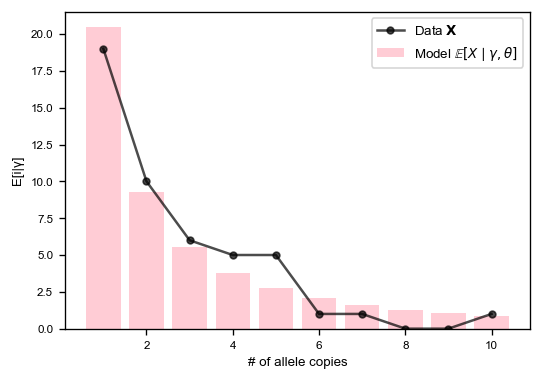

In [51]:
plt.figure(dpi=120)
fs = moments.Spectrum(np.zeros(50),); fs[1] = 1
fs.integrate([0.5],4,gamma=-2,theta=10); fs = fs.project([11])*50/11
plt.bar(x=range(1,11),height=np.array(fs[1:-1]),color='pink',alpha=0.8,label=r'Model $\mathbb{E}[X \mid \gamma,\theta]$'); 
plt.plot(range(1,11), [rng.poisson(fs[i]) for i in range(1,11)],'k-o',alpha=0.7,markersize=4,label=r'Data $\mathbf{X}$'); plt.legend()
plt.xlabel('# of allele copies'); plt.ylabel('E[i|γ]'); 

In [ ]:
plt.scatter(p_xa_s[gamma2[-10]],np.sum(up_xa_s[gamma2[-10]],axis=0),alpha=0.8); plt.loglog(); plt.axline((0,0),(1,1),ls='--')

In [ ]:
plt.imshow(up_xa_s[gamma[15]],aspect='auto',norm=colors.LogNorm(vmax=1e-7,vmin=1e-20)); plt.colorbar()
# np.min(p_xa_s[gamma[4]][10,:])

### Reading in simulation data for comparison

In [53]:
# import os
# os.chdir("/Users/vivaswatshastry/selCoefEst/PReFerSims")
## using the Rcpp code to simulate population allele freqs
# df2 = pd.read_csv("../traindata/trip-2022-03-29.csv")
# df2['gamma'] = df2['gamma'].round(decimals=2)
# df2['empty'] = ''
# df2['empty2'] = ''
# df2['sXl'] = rng.binomial(n=2000, p=df2['Xl'])
# gamma = np.unique(df2['gamma'])
## using PReFerSim to simulate sample allele freqs (already simulated, just reading in)
gamma = np.array([-100.,-30.,-10.,-3.,-1.])
Xldata = np.empty(1,dtype='int'); aldata = np.empty(1,dtype='int'); gldata = np.empty(1)
for g in gamma:
    df = pd.read_csv("outfiles/ConstantSize{}_n400_sim{}.3.full_out.txt".format(-g,12),sep='\t',header=None,)
    df.columns = ['','Xl','s','al','id']
    df['empty'] = ''
    # Xldata.append((df['Xl']*400).astype('int').tolist())
    Xldata = np.append(Xldata,(df['Xl']*400).astype('int').tolist())
    df['al'] = 80000+1 - df['al']
    aldata = np.append(aldata,df['al'].astype('int').tolist())
    gldata = np.append(gldata,np.repeat(g,len(df)))

In [59]:
# df2 = pd.DataFrame({'g':gldata[1:],'X':Xldata[1:],'a':aldata[1:]})
dat2 = df2.to_numpy()

In [8]:
# df1['sXl'] = np.around(df1['Xl']*n).astype(int)
nsites = 2000
idx2keep = np.empty(len(gamma)*nsites,dtype='int')
for ig, _ in enumerate(gamma):
    idx2keep[(ig*nsites):(ig+1)*nsites] = rng.choice(np.where(df2['sXl'][(ig*5000):(ig+1)*5000]>1)[0], nsites, False) + ig*5000
df2 = df2.iloc[idx2keep,:]
dat2 = df2.to_numpy()
df2

NameError: name 'gamma' is not defined

In [ ]:
from statsmodels.distributions.empirical_distribution import ECDF
## PReFerSim selection coefficient is HALF of backward WF sims (need to test this further—simple to rerun cell, but long runtime)
def plot_ecdf_al_sxl(idx):
    indices = np.arange((19*1000),(19+1)*1000)
    indices2 = np.arange((16*1000),(16+1)*1000)
    age1_ecdf = ECDF(df1['al'][::-1].iloc[indices])
    age2_ecdf = ECDF(df2['al'].iloc[indices2])
    x = np.linspace(1,np.max(df2['al'].iloc[indices]))
    y1 = age1_ecdf(x)
    y2 = age2_ecdf(x)
    plt.plot(x, y1, color='green', alpha=0.7, label='PReFerSim vals'); plt.xlabel('age (gens)'); plt.semilogx()
    plt.plot(x, y2, color='purple', alpha=0.7, label='backward approx WF vals'); plt.title('γ={}'.format(gamma[0])); plt.legend()

plot_ecdf_al_sxl(0)

In [ ]:
# df2['gamma'].iloc[np.arange((16*1000),(16+1)*1000)], df1['s'][::-1].iloc[np.arange((19*1000),(19+1)*1000)]

In [ ]:
# interpolate gamma (in other words, I need a denser grid of gamma values around the MLE for better quadratic estimation)
interp_gamma = np.zeros((len(gamma),5))
interp_gamma[0,] = -np.exp(np.linspace(np.log(-gamma[1]),np.log(125),5))
for ig, g in enumerate(gamma[1:-1]):
    interp_gamma[ig+1,] = -np.exp(np.linspace(np.log(-gamma[ig+2]),np.log(-gamma[ig]),5))
interp_gamma[-1,] = -np.exp(np.linspace(np.log(0.7),np.log(-gamma[-2]),5))

In [ ]:
## going through and deleting entries that are very close to each other (tol=1)
interp_gamma = interp_gamma.round(2)
print(interp_gamma)
it_gamma = np.unique(np.hstack((gamma,np.ravel(interp_gamma))))
it_gamma

In [ ]:
## function to obtain the log P(X,|gamma)
def get_lp_xl(g, sXlred, n=2000, cutoff=20):
    """function to compute L(gamma|Xl), where gamma is a range of values and Xl is a given set of freqs"""
    res = np.empty(np.sum((sXlred>cutoff) & (sXlred<n-cutoff+1))) #np.empty(len(Xlred))

    # just performing a search in a look-up table
    for idx, i in enumerate(np.where((sXlred>cutoff) & (sXlred<n-cutoff+1))[0]):
        res[idx] = p_xa_s[g][sXlred[i]]
    
    return np.log(res)

def get_lp_xl2(g, sXlred, n=2000, cutoff=20):
    """function to compute L(gamma|Xl), where gamma is a range of values and Xl is a given set of freqs"""
    res = np.empty(np.sum((sXlred>cutoff) & (sXlred<n-cutoff+1))) #np.empty(len(Xlred))

    # ub = np.exp(2.*g)*scipy.special.expi(-2.*g*0.25/N) - scipy.special.expi(2.*g*(1-0.25/N)) - np.exp(2.*g)*(np.log(0.25/N) - np.log(1-0.25/N))
    # lb = np.exp(2.*g)*scipy.special.expi(2.*g*(0.25/N-1)) - scipy.special.expi(2.*g*0.25/N) - np.exp(2.*g)*(np.log(1-0.25/N) - np.log(0.25/N))
    ub = np.exp(2.*g)*sp.special.expi(-2.*g*0.5*cutoff/n) - sp.special.expi(2.*g*(1-0.5*cutoff/n)) - np.exp(2.*g)*(np.log(0.5*cutoff/n) - np.log(1-0.5*cutoff/n))
    lb = np.exp(2.*g)*sp.special.expi(2.*g*(0.5*cutoff/n-1)) - sp.special.expi(2.*g*0.5*cutoff/n) - np.exp(2.*g)*(np.log(1-0.25/n) - np.log(0.5*cutoff/n))
    scalfact = (ub - lb)/np.expm1(2.*g)

    # return a vector...
    for isx, sx in enumerate(np.where((sXlred>cutoff) & (sXlred<n-cutoff+1))[0]):
        res[isx] = (1-np.exp(-2*g*(1-sXlred[sx]/n)))/(sXlred[sx]/n*(1-sXlred[sx]/n)*(1-np.exp(-2*g)))

    return np.log(res/scalfact)

In [ ]:
## don't need a function since the dict already exists
Xsamp = np.arange(1,n+1)/n
plt.hist([np.argmin(np.abs(dat[i,0]-Xsamp))+1 for i in range(len(dat))],bins=200);

In [ ]:
# plt.hist(newdat[:,2],bins=100)
# plt.hist2d(np.log(newdat[:,0]),newdat[:,2][::-1],(25,25)); plt.colorbar()
# print(newdat[-5:,])
np.where(np.isinf(get_lp_alxl(gamma[-2], newdat[:,0], newdat[:,2], 100)))
# print(newdat[429,])
# get_lp_alxl(gamma[-2], newdat[:,0], newdat[:,2], 100)
# sXlred = np.around(newdat[:,0]*100).astype(int)
# np.sum((sXlred>0) & (sXlred<100))

In [ ]:
import warnings
warnings.filterwarnings('error')
## just doing a lookup of sorts for the right probability
def get_lp_alxl(g, sXlred, alred, n=2000, cutoff=2):
    # Xsamp = np.arange(1,n)/n
    # sXlred = np.around(Xlred*n).astype(int) # rng.binomial(n, Xlred, len(Xlred))
    res = np.empty(np.sum((sXlred>cutoff) & (sXlred<n-cutoff+1)))
    for idx, i in enumerate(np.where((sXlred>cutoff) & (sXlred<n-cutoff+1))[0]):
        # if too many gens, then pass in a very low number (like -400.)
        # res[i] = np.log(p_xa_s[g][-int(alred[i]),np.argmin(np.abs(Xlred[i]-Xsamp))+1]) if (int(alred[i]<p_xa_s[g].shape[0])) else -400. 
        try:
            res[idx] = np.log(up_xa_s[g][-int(alred[i]),sXlred[i]]) if (int(alred[i])<up_xa_s[g].shape[0]) else np.median(np.log(up_xa_s[g][0,cutoff:(n-cutoff+1)]))
        except RuntimeWarning:
            print(g, sXlred[i], alred[i])
        # if np.isinf(res[idx]):
        #     print(i, Xlred[i], alred[i])

    return res

def get_lp_alxl_nocheck(g, sXlred, alred, n=2000, cutoff=2):
    ## version of function with no check for cutoff
    res = np.log(up_xa_s[g][-int(alred),sXlred]) if (int(alred)<up_xa_s[g].shape[0]) else np.median(np.log(up_xa_s[g][0,cutoff:(n-cutoff+1)]))

    return res

In [ ]:
## finding how many alleles have ages beyond computed values in the lookup matrix/table (like 4)
for ig, g in enumerate(gamma):
    alred = df1['al'].iloc[ig*1000:(ig+1)*1000]
    print(g, np.sum(alred>up_xa_s[g].shape[0]))

### Code to run continuous optimization of framework instead of dicrete grid

Here, I will construct a method to compute the likelihood of a given dataset for any $\gamma$ value. 

In [64]:
def get_ll_freq(g, sXlred, n=2000, cutoff=2):
    fs = moments.Spectrum(np.zeros(n+1))
    fs[1] = 1
    fs.integrate([0.5], 10, gamma=g)
    pxs = fs/np.sum(fs[np.arange(cutoff,n-cutoff+1)])

    res = np.empty(np.sum((sXlred>cutoff) & (sXlred<n-cutoff+1))) #np.empty(len(Xlred))

    # just performing a search in a look-up table
    for idx, i in enumerate(np.where((sXlred>cutoff) & (sXlred<n-cutoff+1))[0]):
        res[idx] = pxs[sXlred[i]]
    
    return -np.sum(np.log(res))
@jit(forceobj=True)
def get_ll_freqage(g, sXlred, alred, n=2000, cutoff=2):
    pxas = run_mom_iterate(int(100000+900*g), n, 0.5*g/N, N, 1.25e-8, misc = {'dt_fac':0.02, 'adapt_dt':True})
    
    pxas[:,np.arange(cutoff,n-cutoff+1)] = pxas[:,np.arange(cutoff,n-cutoff+1)]/np.sum(pxas[:,np.arange(cutoff,n-cutoff+1)]) 

    res = np.empty(np.sum((sXlred>cutoff) & (sXlred<n-cutoff+1)),dtype='float32')
    for idx, i in enumerate(np.where((sXlred>cutoff) & (sXlred<n-cutoff+1))[0]):
        res[idx] = np.log(pxas[-int(alred[i]),sXlred[i]]) if (int(alred[i])<pxas.shape[0]) else np.median(np.log(pxas[0,cutoff:(n-cutoff+1)]))

    return -np.sum(res)

In [ ]:
num_sims = 16
parestfreq = np.zeros((4,num_sims))
parestage = np.zeros((4,num_sims))
for ig, g in enumerate([1.,10.,100.]):
    for n in range(num_sims):
        with open('simfiles/ParameterFilesConstant.txt',"r") as file:
            data = file.readlines()

        data[0] = 'MutationRate: {:f}\n'.format(2)
        data[2] = 'DFEPointSelectionCoefficient: {:.8f}\n'.format(-0.5*g/10000)
        data[7] = 'FilePrefix: outfiles/ConstantSize{}_n{}_sim{}_t2\n'.format(-g,400,n)

        with open('simfiles/ParameterFilesConstant.txt', 'w') as file:
            file.writelines(data)
        
        os.system("GSL_RNG_SEED={} GSL_RNG_TYPE=mrg ../../PReFerSim/PReFerSim simfiles/ParameterFilesConstant.txt 3 > /dev/null 2>&1 ".format(rng.integers(100496)))

        dft = pd.read_csv('outfiles/ConstantSize{}_n{}_sim{}_t2.3.full_out.txt'.format(-g,400,n),sep='\t',header=None,names=['','Xl','s','al','id'])
        dft['empty'] = ''
        dft['sXl'] = (dft['Xl']*400).astype('int')
        dft['al'] = 80000+1 - dft['al']
        dft['al'] = dft['al'].astype('int')
        dft = dft.iloc[:,1:]
        datt = dft.to_numpy()

        SMS = np.zeros((80000,400+1),dtype='int16')
        mask = np.zeros_like(SMS); mask[0,:] = 1; mask[:,0] = 1; mask[:,-1] = 1;
        for i in range(len(datt)):
            SMS[datt[i,2],datt[i,5]] += 1
        SMSmask = np.ma.array(SMS,mask=mask)

        sfs = moments.Spectrum(np.histogram(datt[:,5],bins=range(0,402))[0])

        # parestfreq[ig,n] = sp.optimize.minimize_scalar(get_ll_freq, args=(datt[:,5]), options={'xtol': .05,}).x
        # parestage[ig,n] = sp.optimize.minimize_scalar(get_ll_freqage, args=(datt[:,5], datt[:,2]), options={'xtol': .2}).x
        parestfreq[ig,n] = sp.optimize.minimize_scalar(get_ll_freqconstant_notfm,args=({'sfs':sfs,'theta':2,'p_misid':0},400)).x
        parestage[ig,n] = sp.optimize.minimize_scalar(get_ll_freqageconstant_notfm,args=({'sms':SMSmask,'theta':2,'N':10000,'p_misid':0,'gens':80000},400)).x

        print(parestfreq[ig,n],parestage[ig,n])

In [ ]:
sp.optimize.minimize_scalar(get_ll_freqconstant_notfm,args=({'sfs':sfs,'theta':200,'p_misid':0},400)).x, sp.optimize.minimize_scalar(get_ll_freqageconstant_notfm,args=({'sms':SMSmask,'theta':200,'N':10000,'p_misid':0,'gens':80000},400)).x

In [ ]:
# parestfreq, parestage/2
# 10**sp.optimize.minimize_scalar(get_ll_freqageconstant,args=({'sms':SMSmask,'theta':400,'N':10000,'p_misid':0,'gens':80000},400),).x
# 10**sp.optimize.minimize_scalar(get_ll_freqageconstant,args=({'sms':SMSmask,'theta':4,'N':10000,'p_misid':0,'gens':80000},400),).x
# run_mom_iterate_constant??
# -10**sp.optimize.minimize_scalar(get_ll_freqconstant,args=({'sfs':sfs,'theta':400,'p_misid':0},200)).x
# parestfreq.std(axis=1)
# dft = pd.read_csv('PReFerSims/outfiles/ConstantSize0.0.1.full_out.txt',sep='\t',header=None,names=['','Xl','s','al','id'])
# dft['empty'] = ''
# dft['sXl'] = (dft['Xl']*400).astype('int')
# dft['al'] = 80000+1 - dft['al']
# dft['al'] = dft['al'].astype('int')
# dft = dft.iloc[:,1:]
# datt = dft.to_numpy()

# sfs = moments.Spectrum(np.histogram(datt[:,5],bins=range(0,402))[0])
# print(sp.optimize.minimize_scalar(get_ll_freqconstant_notfm,args=({'sfs':sfs,'theta':400,'p_misid':0},400)))

# SMS = np.zeros((80000,400+1),dtype='int16')
# mask = np.zeros_like(SMS); mask[0,:] = 1; mask[:,0] = 1; mask[:,-1] = 1;
# for i in range(len(datt)):
#     SMS[datt[i,2],datt[i,5]] += 1
# SMSmask = np.ma.array(SMS,mask=mask)
# plt.plot(np.linspace(-125,125,20),[get_ll_freqageconstant_notfm(g,{'sms':SMSmask,'theta':4,'N':10000,'p_misid':0,'gens':80000},400) for g in np.linspace(-125,125,20)],'ko')
# sp.optimize.minimize_scalar(get_ll_freqageconstant_notfm,args=({'sms':SMSmask,'theta':400,'N':10000,'p_misid':0,'gens':80000},400))

In [ ]:
# parestfreq = -np.array([[100.756, 104.793, 104.931, 99.876, 98.784, 90.711, 97.843, 101.897, 100.753, 99.271],
#         [9.616, 9.769, 10.315, 9.405, 10.001, 9.913, 9.895, 9.425, 9.713, 10.653],
#         [1.113, 1.151, 1.204, 0.938, 1.036, 0.911, 1.122, 0.915, 1.026, 1.046],
#         [-4.35832402069063e-45, -4.35832402069063e-45, -4.35832402069063e-45, -4.35832402069063e-45, -4.35832402069063e-45, -1.971976596466917e-15, -1.971976596466917e-15, -1.971975942072855e-15, -4.35832402069063e-45, -4.35832402069063e-45, -4.35832402069063e-45]])
# parestage = -np.array([[107.958, 103.559, 111.178, 105.733, 98.938, 95.403, 104.087, 104.810, 103.923, 106.285],
#         [10.354, 9.969, 10.613, 9.571, 10.331, 10.372, 10.616, 9.793, 10.120, 11.210],
#         [1.005, 1.193, 1.148, 0.99, 0.846, 1.126, 0.93, 1.089, 1.044, 1.02]])

# parestage = np.array([[-72.638, -72.416, -72.477, -72.360, -72.582, -72.191, -72.398,
#          -72.534, -72.418, -72.591, -72.341, -72.598, -72.206, -72.451,
#          -72.207, -72.625, -72.508, -72.380, -72.447, -72.224],
#         [-25.950, -26.648, -25.815, -27.308, -26.011, -26.545, -25.472,
#          -26.114, -25.423, -26.061, -25.936, -25.875, -25.913, -26.334,
#          -26.247, -26.006, -27.079, -26.789, -26.381, -26.240],
#         [-11.182, -10.847, -10.509, -10.994, -10.700, -10.616, -10.484,
#          -10.843, -10.313, -11.236, -10.623, -10.742, -10.775, -10.517,
#          -10.198, -10.811, -10.679, -10.517, -11.417, -10.289],
#         [-2.967, -3.017, -3.077, -2.870, -2.618, -3.203, -3.312, -2.521,
#          -2.955, -2.772, -2.618, -2.797, -2.593, -2.700, -3.156, -3.265, -3.135, -2.559, -2.755, -2.576],
#         [-0.995, -0.618, -0.618, -0.618, -0.618, -0.908, -0.618, -0.618,
#          -0.618, -0.618, -0.618, -0.618, -1.181, -0.618, -0.742, -0.618, -0.818, -0.742, -0.618, -0.742]],dtype=float)

# parestfreq = np.array(([[-76.064, -70.595, -72.271, -70.274, -76.273, -66.556, -69.697, -74.476, -70.613, -73.723, -71.448, -74.220, -67.808, -71.549, -66.524, -77.530, -74.721, -71.273, -71.199, -66.284],[-23.513, -25.072, -24.235, -24.239, -23.385, -26.478, -23.393, -25.434, -22.406, -23.127, -24.769, -24.344, -24.670, -24.671, -23.045, -22.772, -27.346, -26.433, -24.705, -23.759],[-9.703, -7.282, -8.675, -7.885, -8.933, -9.850, -6.890, -7.391, -10.592, -7.572, -16.959, -7.963, -6.882, -17.281, -10.580, -19.203, -7.826, -18.361, -10.170, -9.423],[-1.969, -1.924, -1.915, -2.075, -2.034, -2.074, -2.038, -1.928, -2.039, -2.079, -2.634, -2.056, -1.916, -2.645, -2.654, -2.971, -2.752, -1.876,
#        -2.518, -2.279],[-1.346, -0.618, -0.960, -0.618, -0.916, -1.148, -0.618, -0.618,-1.016, -0.824, -0.618, -0.814, -1.439, -0.943, -0.930, -1.000, -1.083, -0.885, -0.950, -0.964]]),dtype=float)

In [ ]:
def setViolColors(bp):
    bp['bodies'][0].set_facecolor('deepskyblue')
    bp['bodies'][0].set_alpha(0.8)
    bp['bodies'][0].set_linewidth(1)
    bp['cbars'].set_colors('grey')
    bp['cbars'].set_alpha(0.6)
    bp['cmins'].set_color('grey')
    bp['cmaxes'].set_color('grey')
    # plt.setp(bp['cbars'][0], color='deepskyblue')
    # plt.setp(bp['caps'][1], color='deepskyblue')
    # plt.setp(bp['whiskers'][0], color='deepskyblue')
    # plt.setp(bp['whiskers'][1], color='deepskyblue')
    # plt.setp(bp['fliers'][0], color='deepskyblue')
    # plt.setp(bp['medians'][0], color='deepskyblue')

    plt.setp(bp['bodies'][1], color='coral', alpha=0.8)
    # plt.setp(bp['cbars'][1], color='coral')
    # plt.setp(bp['caps'][3], color='coral')
    # plt.setp(bp['whiskers'][2], color='coral')
    # plt.setp(bp['whiskers'][3], color='coral')
    # plt.setp(bp['fliers'][1], color='coral')
    # plt.setp(bp['medians'][1], color='coral')

fig = plt.figure(dpi=130)
ax = plt.axes()
s = np.array([-100.,-10.,-1.,0])
# hold(True)

for i in range(len(s)):
    # bp = plt.boxplot([parestfreq[i,~np.isnan(parestfreq[i,:])],parestage[i,~np.isnan(parestage[i,:])]],positions=[3*i+1,3*i+2], widths=0.6,flierprops=dict(marker='x',markersize=5,alpha=0.5),)
    # setBoxColors(bp)
    vp = plt.violinplot([parestfreq[i,:],parestage[i,:]],positions=[3*i+1,3*i+2], widths=0.6,)
    setViolColors(vp)
    plt.axhline(s[i],color='grey',ls='--',alpha=0.6)

# bp = plt.boxplot([parestfreq0,parestage0],positions=[16,17],widths=0.6,flierprops=dict(marker='x',markersize=5,alpha=0.5))
# setBoxColors(bp) 
# vp = plt.violinplot([-parestfreq[-1,:],-parestage[-1,:]],positions=[9,10],widths=0.6,)
# setViolColors(vp)
# plt.axhline(0.,color='grey',ls='--',alpha=0.6);

# ax.set_xticks([1.5,4.5,7.5,10.5,13.5,16.5]); ax.set_xticklabels(np.ravel(s.tolist()+[0.])); ax.set_yscale('symlog');
ax.set_xticks([1.5,4.5,7.5,10.5]); ax.set_xticklabels(np.ravel(s.tolist())); ax.set_yscale('symlog'); ax.set_yticks([-100.,-10.,-1.,0,]); plt.grid()

hB, = plt.plot([1,0],'-',color='deepskyblue'); hR, = plt.plot([1,0],'-',color='coral'); hB.set_visible(False); hR.set_visible(False)
plt.xlabel('true γ value'); plt.ylabel('MLE γ value (20 replicates)')
plt.legend((hB, hR),('freq only, RMSLE: {:.2f}'.format(np.sqrt(np.mean((np.log10(-s+1)-np.log10(np.nanmean(parestfreq,axis=1)))**2))), 'freq & age, RMSLE: {:.2f}'.format(np.sqrt(np.mean((np.log10(-s+1)-np.log10(np.nanmean(parestage,axis=1)))**2)))),loc='upper left')
# plt.savefig("../figs/MLEfreqage2.pdf")

In [ ]:
plt.plot([-100,-10,-1,0],np.std(parestfreq,axis=1)/np.std(parestage,axis=1),'k-o', alpha=0.7); plt.xscale('symlog'); plt.ylabel('ratio of SD'); plt.xlabel(r'$\gamma$'); plt.axhline(1,color='grey')

In [ ]:
dft = pd.read_csv('outfiles/ConstantSize100.0.3.full_out.txt',sep='\t',header=None,names=['','Xl','s','al','id'])
dft['empty'] = ''
dft['sXl'] = (dft['Xl']*400).astype('int')
dft['al'] = 80000+1 - dft['al']
dft['al'] = dft['al'].astype('int')
dft = dft.iloc[:,1:]
datt = dft.to_numpy()

SMS = np.zeros((80000,400+1),dtype='int16')
mask = np.zeros_like(SMS); mask[0,:] = 1; mask[:,0] = 1; mask[:,-1] = 1;
for i in range(len(datt)):
    if (datt[i,2]<80000) & (datt[i,5]<400):
        SMS[datt[i,2],datt[i,5]] += 1
SMSmask = np.ma.array(SMS,mask=mask)

# thetas = np.logspace(0,2,12)
# gammas = np.logspace(-1,2,12,base=10)
# ll2d = np.zeros((len(thetas),len(gammas)))
# for it, t in enumerate(thetas):
#     for ig, g in enumerate(gammas):
#         ll2d[it,ig] = get_ll_freqageconstant(np.log10(g),{'sms':SMSmask,'theta':t,'N':10000,'p_misid':0,'gens':50000},400)

# plt.imshow(-ll2d+np.min(ll2d),vmin=-1000); plt.colorbar(); plt.ylabel(r'$\theta$'); plt.xlabel(r'$\gamma$'); plt.yticks(np.arange(0,12,3),labels=np.round(thetas[::3],1)); plt.xticks(np.arange(0,12,3),labels=np.round(gammas[::3],1)); plt.plot(8,4,'kx'); plt.axvline(8.3,color='red')
# plt.plot(np.linspace(1,10,5),[get_ll_freqageconstant(np.log10(10),{'sms':SMSmask,'theta':t,'N':10000,'p_misid':0,'gens':20000},200) for t in np.linspace(1,10,5)])
# get_ll_freqageconstant(np.log10(1),{'sms':SMSmask,'theta':400,'N':10000,'p_misid':0,'gens':100000},400), get_ll_freqageconstant(np.log10(1),{'sms':SMSmask,'theta':4,'N':10000,'p_misid':0,'gens':100000},400), get_ll_freqageconstant(np.log10(1e-7),{'sms':SMSmask,'theta':4,'N':10000,'p_misid':0,'gens':100000},400)
# sp.optimize.minimize_scalar(get_ll_freqageconstant,args=({'sms':SMSmask,'theta':7.2,'N':10000,'p_misid':0,'gens':50000},400))

In [ ]:
SMSmask.sum(axis=0)

#### Relevent error distribution for allele ages
Initially, using a simplification of estimates from Figure 2 in Albers & McVean, 2018 (piecewise-linear fit) with Poisson distributed error. 

In [ ]:
def get_age_err(simal, rng, errvar):
    erral = np.zeros_like(simal,dtype='int')
    mask1 = (simal>0) & (simal<21)
    mask2 = (simal>20) & (simal<1001)
    mask3 = (simal>1000) & (simal<20001)
    mask4 = simal>20000
    
    erral[mask1] = rng.normal(rng.poisson(10+simal[mask1].astype('int')*1.5, ),errvar[0])
    erral[mask2] = rng.normal(rng.poisson(15+simal[mask2].astype('int')*95/98, ),errvar[1])
    erral[mask3] = rng.normal(rng.poisson(700+simal[mask3].astype('int')*6/19, ),errvar[2])
    erral[mask4] = rng.normal(rng.poisson(2000+simal[mask4].astype('int')*80/98, ),errvar[3])

    # erral[mask1] = rng.lognormal(simal[mask1].astype('int')*1.5, 0.02)
    # erral[mask2] = rng.lognormal(15+simal[mask2].astype('int')*95/98, 0.02)
    # erral[mask3] = rng.lognormal(400+simal[mask3].astype('int')*11/19, 0.02)
    # erral[mask4] = rng.lognormal(2000+simal[mask4].astype('int')*80/98, 0.02)

    return erral

In [ ]:
# rng = np.random.RandomState(234)
# errvar = [20,100,200,1500]
errvar = np.repeat(0,4)
erral = get_age_err(np.repeat(np.arange(10000)+1,20),rng,errvar)
# plt.hist(erral[mask1],50)
# plt.hist(simal[mask1],50)
plt.figure(dpi=120); plt.scatter(np.repeat(np.arange(10000)+1,20),erral); plt.loglog(); plt.axline((1,1),(100,100),color='grey',ls='--'); plt.grid(); plt.xlabel('true ages', fontsize=9); plt.ylabel('ages with Normal distributed error rates', fontsize=9); plt.xticks(fontsize=10); plt.yticks(fontsize=10)
#plt.plot([1,20],[10,35],color='silver',linewidth=1.5); plt.plot([20,1000],[35,1035],color='silver',linewidth=1.5)
# mask1 = (simal>0) & (simal<21)
# mask2 = (simal>20) & (simal<1001)
# mask3 = (simal>1000) & (simal<20001)
# mask4 = simal>20000

In [ ]:
# np.repeat(np.arange(5000)+1,10)

In [ ]:
# trueg1 = -0.01
trueg2 = gamma[-10]
# newdf1 = df1.iloc[np.ravel(np.where(dat[:,1]==trueg1)),0:3].append(df1.iloc[np.ravel(np.where(dat[:,1]==trueg2)),0:3])
newdf1 = df1.iloc[np.ravel(np.where(dat[:,1]==trueg2)),:]
newdat = newdf1.to_numpy()

print(gamma2[np.argmax([np.sum(get_lp_xl(g1, newdat[:,5], cutoff=2)) for g1 in gamma2])])
print(gamma2[np.argmax([np.sum(get_lp_alxl_nocheck(g1, newdat[:,5], newdat[:,2], cutoff=2)) for g1 in gamma2])])

In [ ]:
[np.sum(get_lp_xl(g1, newdat[:,5], cutoff=2)) for g1 in gamma2]

In [ ]:
llfreq, llage = np.zeros(len(gamma2)), np.zeros(len(gamma2))
for ig, g in enumerate(gamma2):
    llfreq[ig] = get_lp_xl(g, newdat[:,5], cutoff=2)
    llfreq[ig] = get_lp_alxl(g, newdat[:,5], newdat[:,2], cutoff=2)

In [ ]:
## getting parametric bootstrap, basically compute MLE s for each data point and then find the 95% CI/2 std to get info measure
mlegfreq = np.zeros((len(gamma),len(newdat)))
mlegage = np.zeros((len(gamma),len(newdat)))
for it, trueg2 in enumerate(gamma): 
    newdf1 = df1.iloc[np.ravel(np.where(dat[:,1]==trueg2)),:]
    newdat = newdf1.to_numpy()
    for i in range(len(newdat)):
        mlegfreq[it,i] = gamma2[np.argmax([np.log(p_xa_s[g1][newdat[i,5]]) for g1 in gamma2])]
        # mlegfreq[it,i] = gamma2[np.argmax([sp.stats.poisson.logpmf(newdat[i,5],mu=p_xa_s[g1][newdat[i,5]]) for g1 in gamma2])]
        mlegage[it,i] = gamma2[np.argmax([get_lp_alxl_nocheck(g1, newdat[i,5], newdat[i,2], cutoff=2) for g1 in gamma2])]
        # mlegage[it,i] = gamma2[np.argmax([sp.stats.poisson.logpmf(newdat[i,5],mu=np.exp(get_lp_alxl_nocheck(g1, newdat[i,5], newdat[i,2], cutoff=2))) for g1 in gamma2])]

In [ ]:
np.sum(mlegfreq,axis=1)

In [ ]:
# plt.scatter(newdat[:,5],mleg,alpha=0.4); plt.xlabel('# of derived alleles'); plt.ylabel('MLE γ'); plt.axhline(trueg2, ls='--', color='red')
plt.boxplot(np.array([mlegfreq[5,],mlegage[5,]]).T,labels=['freq only', 'freq & age']); plt.axhline(gamma[5],color='red',ls='--'); 

In [ ]:
plt.plot(gamma,mlegfreq.std(axis=1/mlegage.std(axis=1),color='k',alpha=0.7); plt.axhline(1,color='grey',ls='--'); plt.grid(); 
plt.xlabel('γ'); plt.ylabel('SD of freq/SD of freq & age')

In [ ]:
plt.scatter(get_lp_xl(g, newdat[:,5], cutoff=10), get_lp_xl2(g, newdat[:,5], cutoff=10), alpha=0.7, color='k', s=2.5); 
plt.axline((-5.75,1.75),slope=1.,color='grey',ls='--',linewidth=0.5);
plt.xlabel('p(X|γ) using moments framework'); plt.ylabel('using PRF approx')

In [ ]:
sin_onlyfreq = np.empty(len(gamma2))
sin_onlyage = np.empty(len(gamma2))
# num_sims = 3
# num_samps = [35,350,3500]
# info_onlyfreq, info_onlyage = np.zeros((len(num_samps),num_sims)), np.zeros((len(num_samps),num_sims))
# nboot = 10
# for i in range(nboot):
#     newdat = newdat[np.random.choice(len(newdat),1000,replace=True)]
    # for ig, g in enumerate(gamma):
        # sum log prob for each locus
        # sin_onlyfreq[ig] = np.sum(get_lp_xl(g, newdat[:,5], cutoff=2))
        # sin_onlyage[ig] = np.sum(get_lp_alxl(g, newdat[:,5], newdat[:,2], cutoff=2))
        # mle = get_boot_ci(newdat,nboot=2)
    # print(gamma[np.argmax(sin_onlyfreq)], gamma[np.argmax(sin_onlyage)])

for ig, g in enumerate(gamma2):
    sin_onlyfreq[ig] = np.sum(get_lp_xl(g, newdat[:,5], cutoff=2))
    sin_onlyage[ig] = np.sum(get_lp_alxl(g, newdat[:,5], newdat[:,2], cutoff=2))

# mle = get_boot_ci(newdat,nboot=20)
# mle.mean(axis=0), mle.std(axis=0)

# for ins, ns in enumerate(num_samps):
#     info_onlyfreq[ins,:], info_onlyage[ins,:] = get_info_content(newdat, num_samps=ns, num_sims=num_sims, cutoff=2)

In [ ]:
# get_mean_sd_werr(newdat, nreps=10)

In [ ]:
## compute gain in information for the same number of sites but over a range of gamma
gain_info = np.empty((3,num_sims))
info_onlyfreq, info_onlyage = np.zeros_like(gain_info), np.zeros_like(gain_info)
# for ig, g in enumerate(gamma):
#     newdf1 = df1.iloc[np.ravel(np.where(dat[:,1]==g)),:]
#     newdat = newdf1.to_numpy()

#     info_onlyfreq[2,:], info_onlyage[2,:] = get_info_content(newdat, num_samps=5000, num_sims=num_sims, cutoff=2)
#     gain_info[ig,:] = np.divide(info_onlyage[2,:],info_onlyfreq[2,:])

## but need to resimulate a bunch of new sites for each gamma (do it only for 1, 10, 100 first)
for ig, g in enumerate([-1., -10., -100.]):
    for n in range(num_sims):
        with open('simfiles/ParameterFilesConstant.txt',"r") as file:
            data = file.readlines()

        data[0] = 'MutationRate: {:f}\n'.format(250)
        data[2] = 'DFEPointSelectionCoefficient: {:.8f}\n'.format(-0.25*g/10000)
        data[7] = 'FilePrefix: outfiles/ConstantSize{}\n'.format(-g)

        with open('simfiles/ParameterFilesConstant.txt', 'w') as file:
            file.writelines(data)
        
        os.system("GSL_RNG_SEED={} GSL_RNG_TYPE=mrg ../../PReFerSim/PReFerSim simfiles/ParameterFilesConstant.txt 3 > /dev/null 2>&1 ".format(rng.integers(100496)))

        dft = pd.read_csv('outfiles/ConstantSize{}.3.full_out.txt'.format(-g),sep='\t',header=None,names=['','Xl','s','al','id'])
        dft['empty'] = ''
        dft['sXl'] = (dft['Xl']*2000).astype('int')
        dft['al'] = 80000+1 - dft['al']
        dft['al'] = dft['al'].astype('int')
        dft = dft.iloc[:,1:]
        if(len(dft)>1000):
            datt = dft.sample(n=1000).to_numpy()
        else: 
            datt = dft.to_numpy()

        info_onlyfreq[ig,n], info_onlyage[ig,n] = get_info_content(datt, num_samps=len(datt), num_sims=1, cutoff=2)
    
    gain_info[ig,:] = np.divide(info_onlyage[ig,:],info_onlyfreq[ig,:])
    # print(gain_info[ig,:])

In [ ]:
# gain_info[1,:] = [1.412, 1.498, 1.583, 1.728, 1.718, 1.688, 1.489, 1.541, 1.494, 1.526, 1.440, 1.337, 1.306, 1.564, 1.461, 1.488]
# gain_info[2,:] = [1.546, 1.551, 1.545, 1.556, 1.542, 1.547, 1.537, 1.538, 1.532, 1.544, 1.546, 1.543, 1.539, 1.551, 1.553, 1.554]
# gain_info[0,:] = [np.nan, 1.100, 1.132, 1.092, 1.088, 1.098, 1.104, 1.090, 1.130, 1.099, 1.122, 1.093, 1.094, 1.105, 1.105, 1.118]
# (array([1.962, 2.510, 2.103, 1.538, 1.352, 1.590]),
#  array([0.267, 0.974, 0.428, 0.224, 0.032, 0.011]))
# array([[1.814, 1.361, 1.377, 1.944, 1.836, 1.736, 0.520, 1.882, 1.884,
#         1.469, 1.042, 0.974, 1.816, 1.457, 2.198, 2.188],
#        [0.074, 0.082, 0.077, 0.176, 0.080, 0.068, 0.077, 0.087, 0.076,
#         0.075, 0.070, 0.072, 0.078, 0.073, 0.070, 0.164],
#        [1.502, 1.510, 1.494, 1.521, 1.512, 1.539, 1.526, 1.513, 1.521,
#         1.517, 1.512, 1.532, 1.483, 1.505, 1.522, 1.516]])
# gain_info.mean(axis=1), gain_info.std(axis=1)
# mean and sd of -0.1, -1., -10., -100 under 2 different regimes (no error, low GEVA error)
gain_info_mean = np.array([[1.048, 0.988, 1.005, 1.019, 1.011, 1.32, 1.484, 1.435, 1.494]])
gain_info_sd = np.array([[0.121, 0.06, 0.027, 0.038, 0.017, 0.42, 0.059, 0.135, 0.149]])
# gain_info_mean = np.array([[1.048, 1.005, 1.484, 1.494],[0.821,0.838,1.037,1.307]])
# gain_info_sd = np.array([[0.121, 0.027, 0.059, 0.149],[0.01,0.037,0.222,0.234]])
# no point in computing the gain in information under high error since MLE is not even the same...
# gamma[2:]

In [ ]:
print(info_onlyage, info_onlyfreq)
print(gain_info)

In [ ]:
# np.divide(infoage, infofreq)
np.abs([get_bfq(ll_adam, gamma2)[0], get_bfq(sin_onlyfreq, gamma2)[0], get_bfq(sin_onlyage, gamma2)[0]])
# -get_bfq(ll_adam-np.max(ll_adam), gamma2)[1]*0.5/get_bfq(ll_adam-np.max(ll_adam), gamma2)[0], -get_bfq(sin_onlyfreq-np.max(sin_onlyfreq), gamma2)[1]*0.5/get_bfq(sin_onlyfreq-np.max(sin_onlyfreq), gamma2)[0], -get_bfq(sin_onlyage-np.max(sin_onlyage), gamma2)[1]*0.5/get_bfq(sin_onlyage-np.max(sin_onlyage), gamma2)[0]

In [ ]:
# seaborn.stripplot(data=pd.DataFrame(gain_info.T,columns=gamma),color='salmon',alpha=0.8,size=7); 
# plt.xlabel('|γ|'); plt.ylabel('gain in information'); plt.title('20 reps of 5000 sites'); plt.grid();
plt.figure(dpi=130)
plt.scatter(np.array([0.099,0.299,0.99,1.77,3.29,7.29,9.9,29,98]),gain_info_mean[0,:],color='slategrey',alpha=0.9,); 
# plt.scatter(np.array([0.11,1.01,10.1,102]),gain_info_mean[1,:],color='lightsteeldeepskydeepskydeepskyblue',alpha=0.9,label='GEVA error'); plt.grid()
plt.errorbar(np.array([0.099,0.299,0.99,1.77,3.29,7.29,9.9,29,98]),gain_info_mean[0,:],yerr=gain_info_sd[0,:],color='slategrey',alpha=0.9,linewidth=2,ls='none'); plt.xticks(fontsize=10); plt.yticks(fontsize=10)
# plt.errorbar(np.array([0.11,1.01,10.1,102]),gain_info_mean[1,:],yerr=gain_info_sd[1,:],color='lightsteelblue',alpha=0.9,linewidth=2,ls='none'); 
# plt.scatter(-gamma[2:],gain_info[0],alpha=0.8,color='k'); plt.semilogx(); plt.xlabel('|γ|'); plt.title('20 reps of 1000 sites')
# plt.errorbar(-gamma[2:],gain_info[0],yerr=2*gain_info[1],color='k',alpha=0.8); plt.grid(); plt.ylabel('gain in info'); 
plt.axhline(1.,color='grey',ls='--',linewidth=2,alpha=0.7); plt.ylabel('ratio of curvature +/- 1 SD', fontsize=10); plt.xlabel('|γ|', fontsize=16); plt.semilogx(); plt.grid(); #plt.legend(loc=2)

#### Working with Adam's log-likelihoods
(and data, since we only need a subset of alleles...)

In [ ]:
# ll_adam = np.array([-12779.905577243711,-12779.67560657378,-12779.345559393892,-12778.872363586619,-12778.19492458077,-12777.22714620313,-12775.848879337178,-12773.89494812682,-12771.143604153498,-12767.30870429352,-12762.046666304424,-12755.004172803323,-12745.96462111521,-12735.2182496041,-12724.415368038992,-12718.41220639416,-12729.002025638603,-12781.678920760727,-12925.363284151737,-13238.84902857637]) # using ~ 500 trajectories
ll_adam=np.array([-29565.76313316775,-29565.621718394377,-29565.418924835354,-29565.128508755162,-29564.713434007765,-29564.121904008814,-29563.282471330967,-29562.098695611345,-29560.44496421317,-29558.16773914124,-29555.102378376516,-29551.12840744588,-29546.313073918434,-29541.248815564642,-29537.801653373364,-29540.693962031066,-29560.662504959695,-29620.153166439388,-29761.530313756353,-30052.589833320435]) # using ~3000 trajectories 
# plt.plot(-gamma2,ll_adam-np.max(ll_adam),'-o',alpha=0.5,label='full traj',color='k'); plt.grid(); plt.plot(-gamma2, sin_onlyfreq-np.max(sin_onlyfreq),'-o',alpha=0.5,label="only freq",color='deepskyblue'); plt.plot(-gamma2,sin_onlyage-np.max(sin_onlyage),'-o',alpha=0.5,label="freq & age",color='coral'); plt.ylim((-200,10)); plt.semilogx()
plt.plot(-gamma2,ll_adam-np.max(ll_adam),'-o',alpha=0.5,label='full traj',color='k'); plt.grid(); plt.plot(-gamma2, np.sum(mlegfreq,axis=1)-np.max(np.sum(mlegfreq,axis=1)),'-o',alpha=0.5,label="only freq",color='deepskyblue'); plt.plot(-gamma2,np.sum(mlegage,axis=1)-np.max(np.sum(mlegage,axis=1)),'-o',alpha=0.5,label="freq & age",color='coral'); plt.ylim((-200,10)); plt.semilogx()
#plt.axvline(-gamma2[np.argmax(sin_onlyage)],color='grey',ls='--'); 
plt.axvline(100.,color='red',); plt.xlabel('|γ|'); plt.ylabel('log-lik'); plt.legend()

In [ ]:
plt.scatter(dft.loc[dft['id'].isin(alls['IDs'])]['sXl']/20,dft.loc[dft['id'].isin(alls['IDs'])]['al'],color='grey',alpha=0.7); plt.xlabel('allele freq (%)'); plt.ylabel('allele age'); plt.semilogy()
# datt = dft.loc[dft['id'].isin(alls['IDs'])].to_numpy()

In [ ]:
plt.scatter(-np.repeat(gamma,num_sims),gain_info,s=10,color='salmon',alpha=0.6); plt.semilogx()
plt.xlabel('|γ|'); plt.ylabel('gain in information'); plt.title('20 reps of 5000 sites'); plt.grid();

In [ ]:
def get_boot_ci(newdat, nsamps=1000, nboot=20, cutoff=2):
    mle = np.zeros((nboot,2))
    sin_onlyfreq, sin_onlyage = np.empty(len(gamma2)), np.empty(len(gamma2))
    for i in range(nboot):
        newnewdat = newdat[np.random.choice(len(newdat),nsamps,replace=True)]
        for ig, g in enumerate(gamma2):
            sin_onlyfreq[ig] = np.sum(get_lp_xl(g, newnewdat[:,5], cutoff=cutoff))
            sin_onlyage[ig] = np.sum(get_lp_alxl(g, newnewdat[:,5], newnewdat[:,2], cutoff=cutoff))
        
        mle[i,0] = gamma2[np.argmax(sin_onlyfreq)]
        mle[i,1] = gamma2[np.argmax(sin_onlyage)]

    return mle            

In [ ]:
def get_mean_sd_werr(newdat, errvar, nreps=20, cutoff=2):
    ests = np.zeros(nreps)
    sin_onlyage = np.empty(len(gamma2))
    for i in range(nreps):
        newage = get_age_err(newdat[:,2],rng,errvar)
        sin_onlyage = [np.sum(get_lp_alxl(g, newdat[:,5], newage, cutoff=cutoff)) for g in gamma2]
        
        ests[i] = gamma2[np.argmax(sin_onlyage)]
    
    return ests

In [ ]:
seaborn.stripplot(data=pd.DataFrame(np.divide(info_onlyage, info_onlyfreq).T,columns=num_samps),color='salmon',alpha=0.8); 
plt.xlabel('# of sites'); plt.ylabel('gain in information'); plt.title('γ = {:.1f}'.format(trueg2)); plt.grid(); 

In [ ]:
seaborn.stripplot(data=pd.DataFrame(info_onlyfreq.T,columns=num_samps), color='deepskyblue', alpha=0.7, label='only freq')
seaborn.stripplot(data=pd.DataFrame(info_onlyage.T,columns=num_samps), color='coral', alpha=0.7, label='freq & age')
plt.xlabel('# of sites'); plt.ylabel('information measure'); plt.grid(); plt.title('γ = {:.1f}'.format(trueg2)); 
plt.legend(handles=[mpatches.Patch(color='deepskyblue', label='only freq, total info: {:.2f}'.format(np.sum(info_onlyfreq))), mpatches.Patch(color='coral', label='freq & age, total info: {:.2f}'.format(np.sum(info_onlyage)))])

In [ ]:
def get_info_content(newdat, num_samps=800, num_sims=16, cutoff=2):
    ci_freq, ci_age = np.zeros(num_sims), np.zeros(num_sims)
    for n in range(num_sims):
        newnewdat = newdat[rng.choice(newdat.shape[0], num_samps, replace=False),:]
        sin_onlyfreq = [np.sum(get_lp_xl(g1, newnewdat[:,5], cutoff=cutoff)) for g1 in gamma2]
        sin_onlyage = [np.sum(get_lp_alxl(g1, newnewdat[:,5], newnewdat[:,2], cutoff=cutoff)) for g1 in gamma2]

        ci_freq[n] = np.abs(get_bfq(sin_onlyfreq-np.max(sin_onlyfreq), gamma2)[0])
        ci_age[n] = np.abs(get_bfq(sin_onlyage-np.max(sin_onlyage), gamma2)[0])

    return [ci_freq, ci_age]

In [ ]:
def get_info_content_werr(newdat, errvar, num_samps=800, reps=16, cutoff=2):
    ci_freq, ci_age = np.zeros(reps), np.zeros(reps)
    for n in range(reps):
        newnewdat = newdat[rng.choice(newdat.shape[0], num_samps, replace=False),:]
        sin_onlyfreq = [np.sum(get_lp_xl(g1, newnewdat[:,5], cutoff=cutoff)) for g1 in gamma2]
        ci_freq[n] = np.abs(get_bfq(sin_onlyfreq-np.max(sin_onlyfreq), gamma2)[0])
        for r in range(reps):
            newage = get_age_err(newnewdat[:,2],rng,errvar)
            sin_onlyage = [np.sum(get_lp_alxl(g1, newnewdat[:,5], newage, cutoff=cutoff)) for g1 in gamma2]
            # print(gamma2[np.argmax(sin_onlyage)])
            ci_age[n] += np.abs(get_bfq(sin_onlyage-np.max(sin_onlyage), gamma2)[0])

    return [ci_freq, ci_age/reps]

In [ ]:
def get_conf_int(loglik, thresh=2):
    mle = gamma[np.argmax(loglik)]

    if mle==np.min(gamma):
        lower_thresh = gamma[1]  
        return [(np.max(loglik)-thresh-loglik[np.argmax(loglik)+1])/(np.max(loglik) - loglik[np.argmax(loglik)+1])/(mle - lower_thresh)+lower_thresh, mle]
    elif mle==np.max(gamma):
        upper_thresh = gamma[-2] 
        return [mle, -thresh/(loglik[np.argmax(loglik)-1] - np.max(loglik))/(upper_thresh - mle)+mle]
    else:
        lower_thresh = gamma[np.argmax(loglik)+1] 
        upper_thresh = gamma[np.argmax(loglik)-1] 
        return [(np.max(loglik)-thresh-loglik[np.argmax(loglik)+1])*(mle - lower_thresh)/(np.max(loglik) - loglik[np.argmax(loglik)+1])+lower_thresh, -thresh*(upper_thresh - mle)/(loglik[np.argmax(loglik)-1] - np.max(loglik))+mle,]
        # return [(np.max(loglik)-thresh-loglik[np.argmax(loglik)+1])/(np.max(loglik) - loglik[np.argmax(loglik)+1])/(mle - lower_thresh)+lower_thresh, -thresh/(loglik[np.argmax(loglik)-1] - np.max(loglik))/(upper_thresh - mle)+mle]

In [ ]:
## run the same search on a denser grid
win_sin_onlyfreq = np.empty(interp_gamma.shape[1])
for ig, g in enumerate(interp_gamma[np.argmax(sin_onlyfreq),]):
    win_sin_onlyfreq[ig] = np.sum(get_lp_xl(g, newdat[:,5], cutoff=10))

win_sin_onlyage = np.empty(interp_gamma.shape[1])
for ig, g in enumerate(interp_gamma[np.argmax(sin_onlyage),]):
    win_sin_onlyage[ig] = np.sum(get_lp_alxl(g, newdat[:,5], newdat[:,2], cutoff=10))

In [ ]:
densegrid = -np.logspace(0,2,base=10,num=100)
lxlbfq = get_bfq(sin_onlyfreq-np.max(sin_onlyfreq), gamma) @ np.vstack((densegrid**2, densegrid,np.repeat(1.0,100)))
# lxlbfq = get_bfq_win(sin_onlyfreq-np.max(sin_onlyfreq), gamma) @ np.vstack((np.repeat(1.0,len(gamma)), gamma, gamma**2,))
# lxlalbfq = np.polynomial.polynomial.Polynomial.fit(gamma[7:10],(sin_onlyage-np.max(sin_onlyage))[7:10],deg=2).coef @ np.vstack((np.repeat(1.0,4), gamma[(np.argmax(sin_onlyage)-1):(np.argmax(sin_onlyage)+3)], gamma[(np.argmax(sin_onlyage)-1):(np.argmax(sin_onlyage)+3)]**2,))
lxlalbfq = get_bfq(sin_onlyage-np.max(sin_onlyage), gamma) @ np.vstack((densegrid**2, densegrid,np.repeat(1.0,100)))
# lxlalbfq = get_bfq_win(sin_onlyage-np.max(sin_onlyage), gamma) @ np.vstack((np.repeat(1.0,len(gamma)), gamma, gamma**2,))

In [ ]:
plt.plot(-gamma2, sin_onlyfreq-np.max(sin_onlyfreq),'grey', label='freq'); plt.ylim((-10,1)); plt.xlabel('est gamma')
plt.axvline(-gamma2[np.argmax(sin_onlyfreq)], color='grey', linestyle='--'); 
# plt.plot(-densegrid, lxlbfq-np.max(lxlbfq), color='deepskyblue', alpha=0.6,label='best-fit quadratic Xl');#interp_gamma
plt.axvline(1., color='red', ls='--'); plt.semilogx()
plt.plot(-gamma2, sin_onlyage-np.max(sin_onlyage),'k', label='freq & age'); plt.ylim((-10,1)); 
# plt.plot(-densegrid, lxlalbfq-np.max(lxlalbfq), color='coral', alpha=0.6,label='best-fit quadratic Xl, al');#interp_gamma[np.argmax(sin_onlyage)]
plt.axvline(-gamma2[np.argmax(sin_onlyage)], color='k', linestyle='--'); plt.ylabel('log-lik units'); plt.legend(); plt.grid()
plt.axhline(-2.,color='red',alpha=0.5)

In [ ]:
def get_bfq(loglik, gamma):
    ## does not work for some reason—wasted multiple hours on it...
    # return np.polynomial.polynomial.Polynomial.fit(-gamma[(ig-3):(ig+3)], loglik[(ig-3):(ig+3)], deg=2)
    igamma = gamma[(np.argmax(loglik)-1):(np.argmax(loglik)+2)] if np.argmax(loglik)>0 else gamma[0:3]
    loglik = loglik[(np.argmax(loglik)-1):(np.argmax(loglik)+2)] if np.argmax(loglik)>0 else loglik[0:3]

    rhs = np.array([np.dot(igamma**2,loglik), np.dot(igamma,loglik), np.sum(loglik)])
    lhs = np.array([[np.sum(igamma**4), np.sum(igamma**3), np.sum(igamma**2)],
    [np.sum(igamma**3), np.sum(igamma**2), np.sum(igamma)],
    [np.sum(igamma**2), np.sum(igamma), len(igamma)]])

    return np.linalg.solve(lhs, rhs) 

In [ ]:
preds_sin_onlyfreq = np.zeros(len(s))
ci_sin_onlyfreq = np.zeros((len(s),2))

for ig, g in enumerate(s):
    newdf1 = df1.iloc[np.ravel(np.where(dat[:,1]==g)),:]
    newdat = newdf1.to_numpy()
    # sin_onlyfreq = [np.sum(get_lp_xl(g1, newdat[:,5], cutoff=5)) for g1 in gamma]
    # preds_sin_onlyfreq[ig] = gamma[np.argmax(sin_onlyfreq)]
    # ci_sin_onlyfreq[ig] = 1/np.abs(get_bfq(sin_onlyfreq - np.argmax(sin_onlyfreq), gamma)[0]) # get_conf_int(sin_onlyfreq)
    info_onlyfreq[ig,:], info_onlyage[ig,:] = get_info_content(newdat, num_samps=1000, num_sims=16)

In [ ]:
# preds_sin_agefreq = np.zeros(len(gamma))
# for ig, g in enumerate(gamma):
#     newdf1 = df1.iloc[np.ravel(np.where(dat[:,1]==g)),:]
#     newdat = newdf1.to_numpy()
#     sin_agefreq = [np.sum(get_lp_alxl(g1, newdat[:,5], newdat[:,2]) + get_lp_xl(g1, newdat[:,5])) for g1 in gamma]
#     # sin_agefreq = [np.sum(get_lp_alxl(g1, newdat[:,0], newdat[:,2], n=100)) for g1 in gamma]
#     preds_sin_agefreq[ig] = gamma[np.nanargmax(sin_agefreq)]

In [ ]:
preds_sin_onlyage = np.zeros(len(gamma))
ci_sin_onlyage = np.zeros((len(gamma),2))
for ig, g in enumerate(gamma):
    newdf1 = df1.iloc[np.ravel(np.where(dat[:,1]==g)),:]
    newdat = newdf1.to_numpy()
    # newdat = newdf1.loc[np.logical_and(newdf1['al']>1, newdf1['al']<60),:].to_numpy()
    sin_onlyage = [np.sum(get_lp_alxl(g1, newdat[:,5], newdat[:,2], cutoff=5)) for g1 in gamma]
    preds_sin_onlyage[ig] = gamma[np.argmax(sin_onlyage)]
    ci_sin_onlyage[ig] = 1/np.abs(get_bfq(sin_onlyage-np.argmax(sin_onlyage), gamma)[0]) # get_conf_int(sin_onlyage)

In [ ]:
## get bootstrap std estimates but mle only calculated once
preds_sin_onlyfreq, preds_sin_onlyage = np.zeros(len(gamma)), np.zeros(len(gamma))
ci_sin_onlyfreq, ci_sin_onlyage = np.zeros((len(gamma),)), np.zeros((len(gamma),))

for ig, g in enumerate(gamma):
    newdf1 = df1.iloc[np.ravel(np.where(dat[:,1]==g)),:]
    newdat = newdf1.to_numpy()
    sin_onlyfreq = [np.sum(get_lp_xl(g1, newdat[:,5], cutoff=2)) for g1 in gamma2]
    sin_onlyage = [np.sum(get_lp_alxl(g1, newdat[:,5], newdat[:,2], cutoff=2)) for g1 in gamma2]
    preds_sin_onlyfreq[ig] = gamma2[np.argmax(sin_onlyfreq)]
    preds_sin_onlyage[ig] = gamma2[np.argmax(sin_onlyage)]
    mle = get_boot_ci(newdat, nsamps=len(newdat), nboot=5)
    ci_sin_onlyfreq[ig,], ci_sin_onlyage[ig,] = mle.std(axis=0) #np.percentile(mle[:,0],[97.5,2.5]), np.percentile(mle[:,1],[97.5,2.5]) 

In [ ]:
## get age estimates but with error introduced into the mix 
preds_sin_onlyfreq, preds_sin_onlyage = np.zeros(len(gamma)), np.zeros(len(gamma))
ci_sin_onlyfreq, ci_sin_onlyage = np.zeros((len(gamma),)), np.zeros((len(gamma),))

for ig, g in enumerate(gamma):
    newdf1 = df1.iloc[np.ravel(np.where(dat[:,1]==g)),:]
    newdat = newdf1.to_numpy()
    sin_onlyfreq = [np.sum(get_lp_xl(g1, newdat[:,5], cutoff=2)) for g1 in gamma2]
    # sin_onlyage = [np.sum(get_lp_alxl(g1, newdat[:,5], newdat[:,2], cutoff=2)) for g1 in gamma2]
    preds_sin_onlyfreq[ig] = gamma2[np.argmax(sin_onlyfreq)]
    ests_age = get_mean_sd_werr(newdat, errvar = np.repeat(0,4), nreps=5)
    # print(ests_age)
    preds_sin_onlyage[ig] = np.mean(ests_age)
    ci_sin_onlyage[ig] = np.std(ests_age)

In [ ]:
# newdf1 = df1.iloc[np.ravel(np.where(dat[:,1]==gamma[-10])),:]
# newdat = newdf1.to_numpy()

In [ ]:
## predictions with data from neutral case only 
dfneut = pd.read_csv("outfiles/ConstantSize0.0.1.full_out.txt",sep='\t',header=None,)
dfneut.columns = ['','Xl','s','al','id']
dfneut['empty'] = ''
dfneut['sXl'] = (dfneut['Xl']*2000).astype('int')
dfneut['al'] = 80000+1 - dfneut['al']
dfneut['al'] = dfneut['al'].astype('int')
dfneut = dfneut.iloc[:,1:]
datneut = dfneut.to_numpy()
dfneut

In [ ]:
shufidx = np.arange(len(datneut))
rng.shuffle(shufidx)
parestfreq0 = np.zeros(11)
parestage0 = np.zeros(11)
for i in range(11):    
    parestfreq0[i] = sp.optimize.minimize_scalar(get_ll_freq, args=(datneut[shufidx[(i*962):((i+1)*962)],5]), options={'xtol': .1,}).x
    parestage0[i] = sp.optimize.minimize_scalar(get_ll_freqage, args=(datneut[shufidx[(i*962):((i+1)*962)],5], datneut[shufidx[(i*962):((i+1)*962)],2]), options={'xtol': .1}).x

In [ ]:
parestfreq0 = np.array([-0.239, 0.230, -0.841, 0.284, 0.088, 0.249, 0.083, -0.115, -0.004, 0.031, -0.003])
parestage0 = np.array([0.027, 0.538, -0.618, 0.680, 0.420, 0.547, 0.420, 0.187, 0.317, 0.382, 0.277])

In [ ]:
# dfhund = pd.read_csv("outfiles/ConstantSize100.0.1.full_out.txt",sep='\t',header=None,).sample(n=2000)
# dfhund.columns = ['','Xl','s','al','id']
# dfhund['empty'] = ''
# dfhund['sXl'] = (dfhund['Xl']*2000).astype('int')
# dfhund['al'] = 100000+1 - dfhund['al']
# dfhund['al'] = dfhund['al'].astype('int')
# dfhund = dfhund.iloc[:,1:]
# dathund = dfhund.to_numpy()
# dfhund

In [ ]:
# plt.hist(dfhund['al'],alpha=0.8); plt.hist(dfneut['al'],alpha=0.4); plt.semilogx()
plt.plot(p_xa_s[gamma2[-5]],'o'); plt.plot(p_xa_s[0.],'o',alpha=0.8); plt.loglog()

In [ ]:
# sin_onlyfreq = [np.sum(get_lp_xl(g1, datneut[:,5], cutoff=2)) for g1 in gamma2]
# sin_onlyage = [np.sum(get_lp_alxl(g1, datneut[:,5], datneut[:,2], cutoff=2)) for g1 in gamma2]
# print(gamma2[np.argmax(sin_onlyfreq)], gamma2[np.argmax(sin_onlyage)])
mle = get_boot_ci(datneut, nsamps=len(datneut), nboot=100)
# mle.std(axis=0)

# plt.scatter(np.repeat(0.001,len(mle)),mle[:,0],alpha=0.5,color='deepskyblue',label='only freq'); plt.ylabel('estimated γ')
# plt.scatter(np.repeat(-.001,len(mle)),mle[:,1],alpha=0.5,color='coral',label='freq & age'); plt.xlabel('true γ'); #plt.semilogy()
# plt.legend(); plt.grid()
# np.corrcoef(mle[:,0],mle[:,1])
# mle.mean(axis=0), mle.std(axis=0)

In [ ]:
## get bootstrap std estimates but mle only calculated once
preds_sin_onlyfreq, preds_sin_onlyage = np.zeros(len(s)), np.zeros(len(s))
ci_sin_onlyfreq, ci_sin_onlyage = np.zeros((len(s),)), np.zeros((len(s),))

for ig, g in enumerate(s):
    newdf1 = df1.iloc[np.ravel(np.where(dat[:,1]==g)),:]
    newdat = newdf1.to_numpy()
    sin_onlyfreq = [np.sum(get_lp_xl(g1, newdat[:,5], cutoff=2)) for g1 in gamma2]
    sin_onlyage = [np.sum(get_lp_alxl(g1, newdat[:,5], newdat[:,2], cutoff=2)) for g1 in gamma2]
    preds_sin_onlyfreq[ig] = gamma2[np.argmax(sin_onlyfreq)]
    preds_sin_onlyage[ig] = gamma2[np.argmax(sin_onlyage)]
    mle = get_boot_ci(newdat, nsamps=len(newdat), nboot=50)
    ci_sin_onlyfreq[ig,], ci_sin_onlyage[ig,] = mle.std(axis=0) #np.percentile(mle[:,0],[97.5,2.5]), np.percentile(mle[:,1],[97.5,2.5]) 

In [ ]:
# newdf1 = df1.iloc[np.ravel(np.where(dat[:,1]==s[4])),:]
# newdat = newdf1.to_numpy()
# sin_onlyfreq = [np.sum(get_lp_xl(g1, newdat[:,5], cutoff=2)) for g1 in gamma2]
# sin_onlyage = [np.sum(get_lp_alxl(g1, newdat[:,5], newdat[:,2], cutoff=2)) for g1 in gamma2]
# gamma2[np.argmax(sin_onlyfreq)], gamma2[np.argmax(sin_onlyage)]
# get_boot_ci(newdat, nsamps=len(newdat), nboot=50)

In [ ]:
## basically, do fitdadi inference for each selection coefficient
## cannot do point selection coefficient inference
import dadi
df = pd.read_csv("PReFerSims/outfiles/ConstantSize2.0.1.full_out.txt", sep="\t", header=None).sample(n=1000)
fs = dadi.Spectrum(np.histogram(fdf.iloc[:, 1] * 2000, bins=2001)[0])
def one_epoch_sel(params, ns, pts):
    nu, T, gamma = params
    xx = dadi.Numerics.default_grid(pts)
    phi = dadi.PhiManip.phi_1D(xx, gamma=gamma)
    phi = dadi.Integration.one_pop(phi, xx, T, nu, gamma=gamma)
    fs = dadi.Spectrum.from_phi(phi, ns, (xx,))
    return fs
pts_l = [600, 800, 1000]
spectra = Selection.spectra(
    [1, 2],
    np.array([2000]),
    one_epoch_sel,
    pts_l=pts_l,
    int_bounds=[0.1, 100],
    Npts=20,
    echo=True,
)
sel_params = [0.1, 200.0]
lower_bound = [1e-3, 1e-2]
upper_bound = [1, 100.0]
p0 = dadi.Misc.perturb_params(sel_params, lower_bound=lower_bound, upper_bound=upper_bound)
popt = Selection.optimize_log(
    p0,
    fs,
    spectra.integrate,
    Selection.normal_dist,
    300,
    lower_bound=lower_bound,
    upper_bound=upper_bound,
    verbose=len(sel_params),
    maxiter=30,
)
spectra.Integrate(popt[1], Selection.normal_dist, 300)
spectra.integrate([1.,4.], Selection.normal_dist, 300)

In [ ]:
plt.scatter(-s, -preds_sin_onlyfreq, color='deepskyblue', alpha=0.5, label='only freq, rel. error: {:.1f}'.format(np.sum(np.abs(s-preds_sin_onlyfreq)*100/-s)),)#s=truenumloci*50/1000)
plt.errorbar(-s, -preds_sin_onlyfreq, yerr=1.96*ci_sin_onlyfreq[:], color='deepskyblue', alpha=0.5, ls='none')
plt.scatter(-s, -preds_sin_onlyage, color='coral', alpha=0.5, label='freq & age, rel. error: {:.1f}'.format(np.sum(np.abs(s-preds_sin_onlyage)*100/-s)),)#s=truenumloci*50/1000)
plt.errorbar(-s, -preds_sin_onlyage, yerr=1.96*ci_sin_onlyage[:], color='coral', alpha=0.5, ls='none')
plt.xlabel('true -γ value'); plt.ylabel('MLE -γ value'); plt.legend(); plt.loglog()
plt.axline((1,1),(100,100),color='grey',ls='--', linewidth=1.); plt.ylim((0.1,1000)); plt.grid()

In [ ]:
plt.scatter(-gamma, -preds_sin_onlyfreq, color='deepskyblue', alpha=0.5, label='only freq, RMSLE: {:.2f}'.format(np.sqrt(np.mean((np.log10(-gamma)-np.log10(-preds_sin_onlyfreq))**2))))#s=truenumloci*50/1000)
# plt.scatter(-gamma, -preds_sin_onlyfreq, color='deepskyblue', alpha=0.5, label='only freq, r2: {:.2f}'.format(sp.stats.pearsonr(np.log(-gamma),np.log(-preds_sin_onlyfreq))[0]**2))
plt.xticks(fontsize=10); plt.yticks(fontsize=10); 
# plt.vlines(-gamma, -ci_sin_onlyfreq[:,0], -ci_sin_onlyfreq[:,1], color='deepskyblue', alpha=0.5)
plt.errorbar(-gamma, -preds_sin_onlyfreq, yerr=1.96*ci_sin_onlyfreq[:], color='deepskyblue', alpha=0.5, ls='none')
plt.errorbar(-gamma, -preds_sin_onlyfreq, yerr=-ci_sin_onlyfreq.T, color='deepskyblue', alpha=0.5, ls='none')
plt.scatter(-gamma, -preds_sin_onlyage, color='coral', alpha=0.5, label='freq & age, RMSLE: {:.2f}'.format(np.sqrt(np.mean((np.log10(-gamma)-np.log10(-preds_sin_onlyage))**2))))#s=truenumloci*50/1000)
# plt.scatter(-gamma, -preds_sin_onlyage, color='coral', alpha=0.5, label='freq & age, r2: {:.2f}'.format(sp.stats.pearsonr(np.log(-gamma),np.log(-preds_sin_onlyage))[0]**2))
# plt.vlines(-gamma, -ci_sin_onlyage[:,0], -ci_sin_onlyage[:,1], color='coral', alpha=0.5)
plt.errorbar(-gamma, -preds_sin_onlyage, yerr=1.96*ci_sin_onlyage[:], color='coral', alpha=0.5, ls='none')
plt.errorbar(-gamma, -preds_sin_onlyage, yerr=-ci_sin_onlyage.T, color='coral', alpha=0.5, ls='none'); plt.yscale('log')
# plt.scatter(-gamma, -preds_sin_agefreq, color='darkgreen', alpha=0.5, label='age & freq, abs. error: {:.1f}'.format(np.sum(np.abs(gamma-preds_sin_agefreq))))
plt.xlabel('true |γ| value', fontsize=10); plt.ylabel('MLE |γ| value', fontsize=10); plt.legend(loc='lower right', fontsize=10); plt.loglog()
plt.axline((1,1),(100,100),color='grey',ls='--', linewidth=1.); plt.ylim((0.2,200)); plt.grid()
# plt.xticks(fontsize=8)
# plt.yticks(fontsize=8)

In [ ]:
# sp.stats.pearsonr(np.log(-gamma),np.log(-preds_sin_onlyfreq))[0]**2
preds_sin_onlyage, preds_sin_onlyfreq

In [ ]:
# dft = pd.read_csv("../traindata/trip-2022-04-05.csv")
# dft['gamma'] = dft['gamma'].round(decimals=2)
preds_sin_onlyfreq

In [ ]:
## comparing empirical distribution from data of frequency values with likelihood from moments framework
# basically take samples from binomial for each rep and then store the values in a vector that keeps getting updated...
ir = np.empty((100,1500),dtype=int)
for n in range(100): #nreps
    ir[n,:] = rng.binomial(n=2000, p=df1[df1['s']==-10.]['Xl'])
counts, bins, _ = plt.hist(np.ravel(ir),bins=2000,range=(0,2000),density=True); plt.semilogx(); plt.xlabel('# of allele copies')
counts[cutoff:(2000-cutoff+1)] = counts[cutoff:(2000-cutoff+1)]/np.sum(counts[cutoff:(2000-cutoff+1)])
counts[0:cutoff] = counts[-cutoff:] = np.repeat(0,cutoff)

In [ ]:
## numerical integration of likelihood to get analytical expression (from eq 2 in Bustamante et al 2001)
def Fanal(gg, i, n):
    with np.errstate(divide='ignore'):
        return [(1-np.exp(-2*gg*(1-x)))*2/((1-np.exp(-2*gg))*x*(1-x)) * sp.stats.binom.pmf(i,n,x) for x in np.logspace(-8,-0.01,99)]

analexp = [sp.integrate.trapezoid(Fanal(-11.625/2,i,2000),np.logspace(-8,-0.01,99)) for i in range(2000)]
analexp[cutoff:(2000-cutoff+1)] = analexp[cutoff:(2000-cutoff+1)]/np.sum(analexp[cutoff:(2000-cutoff+1)])
analexp[0:cutoff] = analexp[-cutoff:] = np.repeat(0,cutoff)

In [ ]:
# np.corrcoef([sp.integrate.trapezoid(Fanal(gamma[19],i,2000),np.linspace(1e-6,1-1e-6,200)) for i in range(20)], [sp.integrate.trapezoid(Fanal(gamma[0],i,2000),np.linspace(1e-6,1-1e-6,200)) for i in range(20)])
# Fanal(gamma[19],10,2000), Fanal(gamma[0],10,2000) 
# np.linspace(1e-6,1-1e-6,20)

In [ ]:
# plt.scatter(p_xa_s[gamma[15]],p_xa_s[gamma[17]]); plt.loglog(); plt.axline((0.1,0.1),(0,0))
# np.allclose(p_xa_s[gamma[19]],p_xa_s[gamma[16]])
gamma2

In [ ]:
plt.scatter(np.arange(2,100+1),p_xa_s[gamma2[15]][2:101],color='purple',label='moments, error={:.2f}'.format(np.sum(np.abs(p_xa_s[gamma2[15]][2:101]-analexp[2:101]))),alpha=0.5);
# plt.scatter(np.arange(2,100+1),testp_xa_s[2:101],color='grey',label='moments2, error={:.2f}'.format(np.sum(np.abs(testp_xa_s[2:101]-analexp[2:101]))),alpha=0.5);
# plt.scatter(np.arange(2,100+1),counts[2:101],color='green',label='PReFerSims, error={:.2f}'.format(np.sum(np.abs(counts[2:101]-analexp[2:101]))),alpha=0.5); 
plt.scatter(np.arange(2,100+1),analexp[2:101],color='lightpink',marker='+',label='analytical expression');  plt.grid(); plt.loglog()
plt.ylabel('probability'); plt.title('γ = {}'.format(-10.)); plt.legend(); plt.xlabel('# of allele copies')

In [ ]:
## plotting different SFS from moments on the same plot
plt.scatter(np.arange(2,100+1),p_xa_s[gamma[0]][2:101],color=cm.get_cmap('Purples',6)(5),alpha=0.6,label='γ={}'.format(gamma[0])); 
plt.scatter(np.arange(2,100+1),p_xa_s[gamma[10]][2:101],color=cm.get_cmap('Purples',6)(3),label='γ={}'.format(gamma[10])); 
plt.scatter(np.arange(2,100+1),p_xa_s[gamma[-1]][2:101],color=cm.get_cmap('Purples',6)(1),label='γ={}'.format(gamma[-1])); 
plt.xlabel('# of allele copies'); plt.ylabel('moments likelihood'); plt.legend(); plt.loglog(); plt.grid()


In [ ]:
preds_sin_onlyfreq, ci_sin_onlyfreq, preds_sin_onlyage, ci_sin_onlyage

In [ ]:
# plt.figure(dpi=150)
import matplotlib.patches as mpatches
seaborn.stripplot(data=pd.DataFrame(info_onlyfreq.T,columns=-gamma[::-1]), color='deepskyblue', alpha=0.7, label='only freq',s=4)
seaborn.stripplot(data=pd.DataFrame(info_onlyage.T,columns=-gamma[::-1]), color='coral', alpha=0.7, label='freq & age',s=4)
plt.semilogy(); plt.xlabel('gamma'); plt.ylabel('information measure'); plt.grid(); 
plt.legend(handles=[mpatches.Patch(color='deepskyblue', label='only freq, total info: {:.2f}'.format(np.sum(info_onlyfreq))), mpatches.Patch(color='coral', label='freq & age, total info: {:.2f}'.format(np.sum(info_onlyage)))])

In [ ]:
## plotting error rates across selection coefficients
plt.plot(-gamma, np.abs(gamma-preds_sin_onlyfreq), color='deepskyblue', alpha=0.8, label='only freq'.format(np.sum(np.abs(gamma-preds_sin_onlyfreq))), ls='--')
plt.plot(-gamma, np.abs(gamma-preds_sin_onlyage), color='coral', label='freq & age', alpha=0.8, ls='--')
plt.legend(); plt.semilogx(); plt.xlabel('-γ'); plt.ylabel('absolute error'); plt.show()

plt.plot(-gamma, -np.abs(gamma-preds_sin_onlyfreq)*100/gamma, color='deepskyblue', alpha=0.8, label='only freq, total: {:.2f}'.format(np.sum(-np.abs(gamma-preds_sin_onlyfreq)*100/gamma)), ls='--')
plt.plot(-gamma, -np.abs(gamma-preds_sin_onlyage)*100/gamma, color='coral', label='freq & age, total: {:.2f}'.format(np.sum(-np.abs(gamma-preds_sin_onlyage)*100/gamma)), alpha=0.8, ls='--')
plt.legend(); plt.semilogx(); plt.xlabel('-γ'); plt.ylabel('relative error'); plt.show()

In [ ]:
## picking a choice of g1 and g2 & creating a new data frame
trueg1 = gamma[-4]
trueg2 = gamma[-10]
# 2000 x 3 (first 1000 is g1, second 1000 is g2)
newdf1 = df1.iloc[np.ravel(np.where(dat[:,1]==trueg1)),:].append(df1.iloc[np.ravel(np.where(dat[:,1]==trueg2)),:])
# newdf1 = newdf1.sample(frac=1)

# only keeping alleles with ages > 1 (cos NN & PRF approx finds really high prob for these alleles to have small gamma...)
newdat = newdf1.to_numpy()

In [ ]:
## need code to do scipy.optimize for two parameters...
def get_ll_freq2(g, sXlred, n=2000, cutoff=2):
    g1, g2 = g

    fs1 = moments.Spectrum(np.zeros(n+1))
    fs1[1] = 1
    fs1.integrate([0.5], 10, gamma=g1)
    pxs1 = fs1/np.sum(fs1[np.arange(cutoff,n-cutoff+1)])

    fs2 = moments.Spectrum(np.zeros(n+1))
    fs2[1] = 1
    fs2.integrate([0.5], 10, gamma=g2)
    pxs2 = fs2/np.sum(fs2[np.arange(cutoff,n-cutoff+1)])

    res = np.empty(np.sum((sXlred>cutoff) & (sXlred<n-cutoff+1))) #np.empty(len(Xlred))

    # just performing a search in a look-up table
    for idx, i in enumerate(np.where((sXlred>cutoff) & (sXlred<n-cutoff+1))[0]):
        res[idx] = np.log(0.5*pxs1[sXlred[i]]+0.5*pxs2[sXlred[i]])
    
    return -np.sum(res)

In [ ]:
def get_ll_freqage2(g, sXlred, alred, n=2000, cutoff=2):
    g1, g2 = g

    pxas1 = run_mom_iterate(int(100000+900*g1), n, 0.5*g1/N, N, 1.25e-8, misc = {'dt_fac':0.02, 'adapt_dt':True})
    pxas1[:,np.arange(cutoff,n-cutoff+1)] /= np.sum(pxas1[:,np.arange(cutoff,n-cutoff+1)]) 

    pxas2 = run_mom_iterate(int(100000+900*g2), n, 0.5*g2/N, N, 1.25e-8, misc = {'dt_fac':0.02, 'adapt_dt':True})
    pxas2[:,np.arange(cutoff,n-cutoff+1)] /= np.sum(pxas2[:,np.arange(cutoff,n-cutoff+1)]) 

    res = np.empty(np.sum((sXlred>cutoff) & (sXlred<n-cutoff+1)))
    
    for idx, i in enumerate(np.where((sXlred>cutoff) & (sXlred<n-cutoff+1))[0]):
        res[idx] = np.log(0.5*pxas1[-int(alred[i]),sXlred[i]] + 0.5*pxas2[-int(alred[i]),sXlred[i]])

    return -np.sum(res)

In [ ]:
# np.sum((newdat[:,5]>cutoff) & (newdat[:,5]<2000-cutoff+1))

In [ ]:
# 0.5*pxs1[newdat[10,5]] + 0.5*pxs2[newdat[10,5]]
# trueg1, trueg2, N, 41843.793
# sp.optimize.minimize(get_ll_freqage2, x0=[trueg1, trueg2], method='L-BFGS-B', args=(newdat[:,5], newdat[:,2]), options={'maxiter':5, 'ftol':1.}, bounds=[(-200,-0.2),(-200,-0.2)])
np.sum((trueg1+24.772)**2+(trueg2+11.16)**2)/2

In [ ]:
# sp.optimize.basinhopping(get_ll_freq2, x0=[-10,-10], minimizer_kwargs={'method': 'L-BFGS-B', 'args': (newdat[:,5]), 'tol': (1., 1.)})
sp.optimize.minimize(get_ll_freq2, x0=[-1,-10], method='L-BFGS-B', args=(newdat[:,5]), options={'maxiter':50, 'ftol':1e-2,}, bounds=[(-200,-0.2),(-200,-0.2)])
# Nelder-Mead: 'xatol':0.25, 'fatol': 1., takes ~1min/iter and progresses slowly (need to initialize close to true for faster convergence)
# sp.optimize.minimize(get_ll_freqage2, x0=[trueg1+1, trueg2+1], method='TNC', args=(newdat[:,5], newdat[:,2]), options={'eps':1e-2,'ftol':1,'xtol':1e-2,'gtol':1e-2,},)

In [ ]:
## assuming two selection coefficients and only freq info (split 50/50)
dub_onlyfreq = np.zeros((len(gamma2),len(gamma2))) # need a 2d search
# for ig1, g1 in enumerate(gamma2):
#     for ig2, g2 in enumerate(gamma2[0:(ig1+1)]):
#         dub_onlyfreq[ig1, ig2] = np.sum(np.log(0.5*np.exp(get_lp_xl(g1, newdat[:,5])) + 0.5*np.exp(get_lp_xl(g2, newdat[:,5]))))

mask = np.full(dub_onlyfreq.shape,False)
mask[np.triu_indices_from(dub_onlyfreq,k=1)] = True

In [ ]:
seaborn.heatmap(dub_onlyfreq,alpha=0.95,cmap='viridis_r',mask=mask,vmax=np.max(dub_onlyfreq[~mask])-5,vmin=np.max(dub_onlyfreq[~mask]))
plt.xticks(np.linspace(0,24,6,dtype='int'),gamma2[np.linspace(0,24,6,dtype='int')].round(2))
plt.yticks(np.linspace(0,24,6,dtype='int'),gamma2[np.linspace(0,24,6,dtype='int')].round(2))
np.take(gamma, np.unravel_index(np.nanargmax(np.ma.masked_array(dub_onlyfreq, mask)),dub_onlyfreq.shape))

In [ ]:
## assuming two selection coefficients and only age info (split 50/50)
dub_onlyage = np.zeros((len(gamma2),len(gamma2))) # need a 2d search
for ig1, g1 in enumerate(gamma2):
    for ig2, g2 in enumerate(gamma2[0:(ig1+1)]):
        dub_onlyage[ig1, ig2] = np.sum(np.log(0.5*np.exp(get_lp_alxl(g1, newdat[:,5], newdat[:,2])) + 
        0.5*np.exp(get_lp_alxl(g2, newdat[:,5], newdat[:,2]))))

In [ ]:
seaborn.heatmap(dub_onlyage,alpha=0.75,xticklabels=gamma,yticklabels=gamma,cmap='Blues',mask=mask,vmin=np.max(dub_onlyage[~mask])-10,vmax=np.max(dub_onlyage[~mask]))
plt.xticks(np.linspace(0,24,6,dtype='int'),gamma2[np.linspace(0,24,6,dtype='int')].round(2))
plt.yticks(np.linspace(0,24,6,dtype='int'),gamma2[np.linspace(0,24,6,dtype='int')].round(2))
np.take(gamma, np.unravel_index(np.argmax(np.ma.masked_array(dub_onlyage, mask)),dub_onlyfreq.shape))

In [ ]:
np.unravel_index(np.argmax(np.ma.masked_array(dub_onlyage, mask)),dub_onlyage.shape)
np.unravel_index(np.nanargmax(np.ma.masked_array(dub_onlyfreq, mask)),dub_onlyfreq.shape)
# print(np.max(dub_onlyfreq[~mask]))
# print(np.max(dub_onlyage[~mask]))
# dub_onlyfreq[24,]
# dub_onlyage[21,]

### What if there was only one $\gamma$ in the data? 

In [ ]:
samepredsonlyfreq = np.zeros((len(gamma),4))
samepredsagefreq = np.zeros((len(gamma),4))
for itg, trueg in enumerate(gamma):
    newdf1 = df1.iloc[np.ravel(np.where(dat[:,1]==trueg)),:]

    newdat = newdf1.to_numpy()
    
    sin_onlyfreq = np.zeros(len(gamma))
    sin_agefreq = np.zeros(len(gamma))
    
    dub_onlyfreq = np.zeros((len(gamma),len(gamma))) # need a 2d search
    dub_agefreq = np.zeros((len(gamma),len(gamma))) # need a 2d search

    for ig1, g1 in enumerate(gamma):
        sin_onlyfreq[ig1] = np.sum(get_lp_xl(g1, newdat[:,5]))
        # sin_agefreq[ig1] = np.sum(get_lp_alxl(g1, newdat[:,0], newdat[:,2], n=100) + get_lp_xl(g1, newdat[:,0]))
        sin_agefreq[ig1] = np.sum(get_lp_alxl(g1, newdat[:,5], newdat[:,2]))

        for ig2, g2 in enumerate(gamma[0:(ig1+1)]):        
            dub_onlyfreq[ig1, ig2] = np.sum(np.log(0.5*np.exp(get_lp_xl(g1, newdat[:,5])) + 0.5*np.exp(get_lp_xl(g2, newdat[:,5]))))
    
            # dub_agefreq[ig1, ig2] = np.sum(np.log(0.5*np.exp(get_lp_alxl(g1, newdat[:,0], newdat[:,2], n=100) + get_lp_xl(g1, newdat[:,0])) + 0.5*np.exp(get_lp_alxl(g2, newdat[:,0], newdat[:,2], n=100) + get_lp_xl(g2, newdat[:,0]))))
            
            dub_agefreq[ig1, ig2] = np.sum(np.log(0.5*np.exp(get_lp_alxl(g1, newdat[:,5], newdat[:,2])) + 0.5*np.exp(get_lp_alxl(g2, newdat[:,5], newdat[:,2]))))

    estgonlyfreq = gamma[np.argmax(sin_onlyfreq)]

    estg1onlyfreq = gamma[np.unravel_index(dub_onlyfreq.argmax(), dub_onlyfreq.shape)[0]]
    estg2onlyfreq = gamma[np.unravel_index(dub_onlyfreq.argmax(), dub_onlyfreq.shape)[1]]

    lambfreq = 2.*(np.max(dub_onlyfreq[~mask]) - np.max(sin_onlyfreq))

    samepredsonlyfreq[itg,2] = estgonlyfreq

    samepredsonlyfreq[itg,:2] = np.take(gamma, np.unravel_index(np.nanargmax(np.ma.masked_array(dub_onlyfreq, mask)),dub_onlyfreq.shape))

    if(chi2.sf(lambfreq, 1)<0.05):
        samepredsonlyfreq[itg,3] = True
    else:
        samepredsonlyfreq[itg,3] = False

    estgagefreq = gamma[np.nanargmax(sin_agefreq)]        

    estg1agefreq = np.take(gamma, np.unravel_index(np.nanargmax(np.ma.masked_array(dub_agefreq, mask)),dub_agefreq.shape))[0]
    estg2agefreq = np.take(gamma, np.unravel_index(np.nanargmax(np.ma.masked_array(dub_agefreq, mask)),dub_agefreq.shape))[1]

    lambagefreq = 2.*(np.nanmax(dub_agefreq[~mask]) - np.nanmax(sin_agefreq))

    samepredsagefreq[itg,2] = estgagefreq

    samepredsagefreq[itg,:2] = np.take(gamma, np.unravel_index(np.nanargmax(np.ma.masked_array(dub_agefreq, mask)),dub_agefreq.shape))

    if(chi2.sf(lambagefreq, 1)<0.05):
        samepredsagefreq[itg,3] = True
    else:
        samepredsagefreq[itg,3] = False

In [ ]:
# np.max(dub_onlyfreq) - np.max(sin_onlyfreq)
samepredsagefreq

In [ ]:
## plotting the above results
plt.scatter(-gamma, -samepredsonlyfreq[:,0], color='deepskyblue', marker='+', alpha=0.5)
plt.scatter(-gamma, -samepredsonlyfreq[:,1], color='deepskyblue', marker='+', label='estimates using only freq', alpha=0.5)
plt.scatter(-gamma, -samepredsagefreq[:,0], color='coral', marker='*', label='estimates using freq & age', alpha=0.5)
plt.scatter(-gamma, -samepredsagefreq[:,1], color='coral', marker='*', alpha=0.5)
plt.xlabel('true -γ value'); plt.ylabel('predicted -γ value(s)'); plt.loglog()
plt.axline((0.01,0.01),(100,100),color='grey',ls='--'); plt.legend()

### Template code to compute difference in $\gamma$ given set of data

Here, I will run the mechanism to compute the probability of a significant difference in selection coefficients is detected given a set of large data i.e., 2000 data points and I will resample 25 times to obtain smaller datasets of 500. 

In [ ]:
# num_sims is number of reps to run to calculate prob
# num_samps is number of rows to resample the big data from
# gamma is np.array of values to calculate over
# thresh is threshold to assign significance
def resample_calculateprob_freq(newdat, gamma, num_sims=16, num_samps=500, thresh=0.05, cutoff=cutoff):
    prob = 0.
    sin_onlyfreq = np.empty(len(gamma))
    dub_onlyfreq = np.zeros((len(gamma),len(gamma)))
    for n in np.arange(num_sims):
        newnewdat = newdat[np.random.choice(newdat.shape[0], num_samps, replace=False),:]
        for ig, g in enumerate(gamma):
            # sum log prob for each locus
            sin_onlyfreq[ig] = np.sum(get_lp_xl(g, newnewdat[:,5], cutoff=cutoff))
            for ig2, g2 in enumerate(gamma[0:(ig+1)]):
                dub_onlyfreq[ig, ig2] = np.sum(np.log(0.5*np.exp(get_lp_xl(g, newnewdat[:,5], cutoff=cutoff)) + 0.5*np.exp(get_lp_xl(g2, newnewdat[:,5], cutoff=cutoff))))


        estgonlyfreq = gamma[np.argmax(sin_onlyfreq)]

        # estg1onlyfreq = gamma[np.unravel_index(dub_onlyfreq.argmax(), dub_onlyfreq.shape)[0]]
        # estg2onlyfreq = gamma[np.unravel_index(dub_onlyfreq.argmax(), dub_onlyfreq.shape)[1]]
        estg1onlyfreq, estg2onlyfreq = np.take(gamma, np.unravel_index(np.argmax(np.ma.masked_array(dub_onlyfreq, mask)),dub_onlyfreq.shape))

        lambfreq = 2.*(dub_onlyfreq[gamma==estg1onlyfreq,gamma==estg2onlyfreq] - sin_onlyfreq[gamma==estgonlyfreq])

        if(chi2.sf(lambfreq, 1)<thresh):
            prob += 1.

    return [prob/num_sims, estgonlyfreq, np.array([estg1onlyfreq, estg2onlyfreq])]

In [387]:
## function call to find MLE using scipy.optimize (and corresponding changes in the next steps for LRT)
## pass in the entire data set & positive gamma and do wrangling inside function
def resample_calculateprob_freqcont(dft, gamma, t=200, n=200, thresh=0.05):
    dft['empty'] = ''
    dft['sXl'] = (dft['Xl']*n).astype('int')
    dft['al'] = 80000+1 - dft['al']
    dft['al'] = dft['al'].astype('int')
    dft = dft.iloc[:,1:]
    datt = dft.to_numpy()
    sfs = moments.Spectrum(np.histogram(datt[:,5],bins=range(0,n+2))[0])
    SMS = np.zeros((80000,n+1),dtype='int16')
    mask = np.zeros_like(SMS); mask[0,:] = 1; mask[:,0] = 1; mask[:,-1] = 1;
    for i in range(len(datt)):
        SMS[datt[i,2],datt[i,5]] += 1
    SMSmask = np.ma.array(SMS,mask=mask)

    ressinf = sp.optimize.minimize_scalar(get_ll_freqconstant,args=({'sfs':sfs,'theta':t,'p_misid':0},n))
    lldubf = get_ll_freqconstant_twogam(np.log10([-gamma[0],-gamma[1]]),{'sfs':sfs,'theta':t,'p_misid':0},n)
    # print(ressinf.fun, lldubf)

    if(chi2.sf(2.*(ressinf.fun - lldubf),1)<thresh):
        probf = 1
    else:
        probf = 0

    # ressina = sp.optimize.minimize_scalar(get_ll_freqageconstant,args=({'sms':SMSmask,'theta':t,'N':10000,'p_misid':0,'gens':80000},n))
    # llduba = get_ll_freqageconstant_twogam(np.log10([-gamma[0],-gamma[1]]),{'sms':SMSmask,'theta':t,'N':10000,'gens':80000},n)
    
    # print(ressina.fun, llduba)
    # if(chi2.sf(2.*(ressina.fun - llduba),1)<thresh):
    #     proba = 1
    # else:
    #     proba = 0
    proba = 1; 

    return [probf, proba, ressinf.x, 1]

In [ ]:
# num_samps is number of rows to resample the big data from
# gamma is np.array of values to calculate over
# thresh is threshold to assign significance
def resample_calculateprob_agefreq(newdat, gamma, num_sims=16, num_samps=500, thresh=0.05):
    prob = 0.

    sin_agefreq = np.empty(len(gamma))
    
    dub_agefreq = np.zeros((len(gamma),len(gamma)))
    for n in np.arange(num_sims):
        newnewdat = newdat[np.random.choice(newdat.shape[0], num_samps, replace=False),:]
        for ig, g in enumerate(gamma):
            # sum log prob for each locus
            sin_agefreq[ig] = np.sum(get_lp_alxl(g, newnewdat[:,0], newnewdat[:,2], n=100) + get_lp_xl(g, newnewdat[:,0]))
            for ig2, g2 in enumerate(gamma[0:(ig+1)]):
                dub_agefreq[ig, ig2] = np.sum(np.log(0.5*np.exp(get_lp_alxl(g, newnewdat[:,5], newnewdat[:,2]) + get_lp_xl(g, newnewdat[:,5])) + 0.5*np.exp(get_lp_alxl(g2, newnewdat[:,5], newnewdat[:,2]) + get_lp_xl(g2, newnewdat[:,5]))))

        estgagefreq = gamma[np.nanargmax(sin_agefreq)]        

        estg1agefreq = gamma[np.unravel_index(np.nanargmax(dub_agefreq[~mask]), dub_agefreq.shape)[0]]
        estg2agefreq = gamma[np.unravel_index(np.nanargmax(dub_agefreq[~mask]), dub_agefreq.shape)[1]]

        lambagefreq = 2.*(dub_agefreq[gamma==estg1agefreq,gamma==estg2agefreq] - sin_agefreq[gamma==estgagefreq])

        if(chi2.sf(lambagefreq, 1)<thresh):
            prob += 1.

    return prob/num_sims

In [ ]:
# num_samps is number of rows to resample the big data from
# gamma is np.array of values to calculate over
# thresh is threshold to assign significance
def resample_calculateprob_age(newdat, gamma, num_sims=16, num_samps=500, thresh=0.05, cutoff=cutoff):
    prob = 0.

    sin_onlyage = np.empty(len(gamma))
    
    dub_onlyage = np.zeros((len(gamma),len(gamma)))
    for n in np.arange(num_sims):
        newnewdat = newdat[np.random.choice(newdat.shape[0], num_samps, replace=False),:]
        for ig, g in enumerate(gamma):
            # sum log prob for each locus
            sin_onlyage[ig] = np.sum(get_lp_alxl(g, newnewdat[:,5], newnewdat[:,2], cutoff=cutoff))
            for ig2, g2 in enumerate(gamma[0:(ig+1)]):
                dub_onlyage[ig, ig2] = np.sum(np.log(0.5*np.exp(get_lp_alxl(g, newnewdat[:,5], newnewdat[:,2], cutoff=cutoff)) + 0.5*np.exp(get_lp_alxl(g2, newnewdat[:,5], newnewdat[:,2], cutoff=cutoff))))

        estgonlyage = gamma[np.argmax(sin_onlyage)]        

        # estg1onlyage = gamma[np.unravel_index(dub_onlyage.argmax(), dub_onlyage.shape)[0]]
        # estg2onlyage = gamma[np.unravel_index(dub_onlyage.argmax(), dub_onlyage.shape)[1]]
        estg1onlyage, estg2onlyage = np.take(gamma, np.unravel_index(np.argmax(np.ma.masked_array(dub_onlyage, mask)),dub_onlyage.shape))

        lambonlyage = 2.*(dub_onlyage[gamma==estg1onlyage,gamma==estg2onlyage] - sin_onlyage[gamma==estgonlyage])

        if(chi2.sf(lambonlyage, 1)<thresh):
            prob += 1.

    return [prob/num_sims, estgonlyage, np.array([estg1onlyage, estg2onlyage])]

In [10]:
# nsims = 15
gamma = [-1.,-2.,-5.,-10.,-20.,-50.,-100.]
diffgamma = np.reshape(list(it.combinations(gamma, 2)), (-1,2)) # np.reshape([(-1., x) for x in gamma[:-1][::2]], (-1,2)) #
# diffgamma = [[-1.,-5.],[-2.,-10.],[-2.,-20.],[-5.,-50.],[-10.,-50.],[-20.,-100.]]
# diffprobsf = np.zeros((len(diffgamma),nsims))
# diffprobsa = np.zeros((len(diffgamma),nsims))
# sinpredsf = np.zeros((len(diffgamma),nsims))
# sinpredsa = np.zeros((len(diffgamma),nsims))
# for ig, g in enumerate(diffgamma[::-1]):
#     print(g)
#     for sim in range(nsims):
#         with open('simfiles/SelPoint.txt', 'r') as file:
#             data = file.readlines()

#         data[0] = '{:d} 0.5\n'.format(int(-g[1]))
#         data[1] = '{:d} 1.0\n'.format(int(-g[0]))

#         with open('simfiles/SelPoint.txt', 'w') as file:
#             file.writelines(data)

#         with open('simfiles/ParameterFilesPoint.txt', 'r') as file:
#             data = file.readlines()
        
#         data[0] = 'MutationRate: {}\n'.format(1000)
#         data[8] = 'FilePrefix: outfiles/Point_g{}_g{}_t{}_sim{}'.format(-g[0],-g[1],1000,sim)

#         with open('simfiles/ParameterFilesPoint.txt', 'w') as file:
#             file.writelines(data)
        
#         os.system("GSL_RNG_SEED={} GSL_RNG_TYPE=mrg ../../PReFerSim/PReFerSim simfiles/ParameterFilesPoint.txt 3 > /dev/null 2>&1 ".format(rng.integers(100496)))

#         dft = pd.read_csv('outfiles/Point_g{}_g{}_t{}_sim{}.3.full_out.txt'.format(-g[0],-g[1],1000,sim),sep='\t',header=None,names=['','Xl','s','al','id'])
#         res = resample_calculateprob_freqcont(dft, g, t=1000)
#         diffprobsf[ig,sim] = res[0]; diffprobsa[ig,sim] = res[1]; sinpredsf[ig,sim] = 10**res[2]; sinpredsa[ig,sim] = 10**res[3]
#         print(res)

In [13]:
# diffprobsf, diffprobsa, sinpredsf, sinpredsa
# np.savetxt(X=np.vstack((diffprobsf,diffprobsa)),fname="resfiles/diffprob_t40.txt")
# os.chdir("/Users/vivaswatshastry/selCoefEst/PReFerSims/")
diffprobsf = np.loadtxt('resfiles/diffprob_t200.txt')[:21,:]; diffprobsa = np.loadtxt('resfiles/diffprob_t200.txt')[21:,:]
# pd.read_csv('outfiles/Point_g{}_g{}_t{}_sim{}.3.full_out.txt'.format(-g[0],-g[1],1000,sim),sep='\t',header=None,names=['','Xl','s','al','id'])

In [18]:
diffprobsf.sum(axis=1), diffprobsa.sum(axis=1)

(array([0.000, 11.000, 15.000, 15.000, 15.000, 15.000, 4.000, 14.000,
        15.000, 15.000, 15.000, 1.000, 13.000, 15.000, 15.000, 2.000,
        13.000, 15.000, 5.000, 11.000, 0.000]),
 array([0.000, 14.000, 15.000, 15.000, 15.000, 15.000, 4.000, 15.000,
        15.000, 15.000, 15.000, 5.000, 13.000, 15.000, 15.000, 4.000,
        15.000, 15.000, 8.000, 15.000, 4.000]))

In [74]:
diffgamma = np.reshape(list(it.combinations(gamma, 2)), (-1,2)) # np.reshape([(-1., x) for x in gamma[:-1][::2]], (-1,2)) #
diffprobs = np.zeros((len(diffgamma),2))
sinpreds = np.zeros((len(diffgamma),2))
dubpreds = np.zeros((len(diffgamma),4))
for ig, g in enumerate(diffgamma):
    newdf1 = df2.iloc[np.ravel(np.where(dat2[:,0]==g[0])),:].append(df2.iloc[np.ravel(np.where(dat2[:,0]==g[1])),:])
    # newdf1 = newdf1.sample(frac=1)
    newdat = newdf1.to_numpy()
    ## continuous pred doesn't do great, worse than using grid! 
    diffprobs[ig,0], sinpreds[ig,0], dubpreds[ig,:2] = resample_calculateprob_freqcont(newdat, gamma, num_sims=5, num_samps=100, cutoff=0)
    # diffprobs[ig,1], sinpreds[ig,1], dubpreds[ig,-2:] = resample_calculateprob_age(newdat, gamma2, num_sims=20, num_samps=1000, cutoff=2)

IndexError: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices

In [199]:
# dft = pd.read_csv('outfiles/Point.3.full_out.txt',sep='\t',header=None,names=['','Xl','s','al','id'])
# dft['empty'] = ''
# dft['sXl'] = (dft['Xl']*200).astype('int')
# dft['al'] = 80000+1 - dft['al']
# dft['al'] = dft['al'].astype('int')
# dft = dft.iloc[:,1:]
# datt = dft.to_numpy()
# sfs = moments.Spectrum(np.histogram(datt[:,5],bins=range(0,202))[0])
# SMS = np.zeros((80000,200+1),dtype='int16')
# mask = np.zeros_like(SMS); mask[0,:] = 1; mask[:,0] = 1; mask[:,-1] = 1;
# for i in range(len(datt)):
#     SMS[datt[i,2],datt[i,5]] += 1
# SMSmask = np.ma.array(SMS,mask=mask)

## with -100 & -1 (~15:85 split), -2.3 & -2.07 estimated with ll = -419 & -4536 respectively
# sp.optimize.minimize_scalar(get_ll_freqconstant,args=({'sfs':sfs,'theta':2,'p_misid':0},200)), sp.optimize.minimize_scalar(get_ll_freqageconstant,args=({'sms':SMSmask,'theta':2,'N':10000,'p_misid':0,'gens':80000},200))
# what if we said there were two gammas in the set? 
# from mom_functions import *
## (-1, -65) & (-1,-90) estimated with ll = -349 & -4449 respectively (age takes ~4 mins)
# sp.optimize.minimize(get_ll_freqconstant_twogam, x0=np.log10([5,50]), method='Nelder-Mead', args=({'sfs':sfs,'theta':200},400), bounds=[(-1,2.5),(-1,2.5)])
# sp.optimize.minimize(get_ll_freqageconstant_twogam, x0=np.log10([1,50]), method='Powell', args=({'sms':SMSmask,'theta':200,'N':10000,'gens':80000},400), bounds=[(-1,2.5),(-1,2.5)])

In [159]:
get_ll_freqconstant_twogam(np.log10([5,50]),{'sfs':sfs,'theta':2,'p_misid':0},200), get_ll_freqageconstant_twogam(np.log10([5,50]),{'sms':SMSmask,'theta':2,'N':10000,'gens':80000},200)

(10.275835831072095, 40.862785)

### Need a way to plot what the predictions are too...

In [ ]:
dubpredsfsame, dubpredsasame

In [ ]:
plt.scatter(range(1,len(diffgamma)+1),diffgamma[:,0],marker='+',color='k',alpha=0.5); plt.scatter(range(1,len(diffgamma)+1),diffgamma[:,1],marker='+',color='k',label='True values'); #plt.yscale('symlog')
plt.scatter(range(1,len(diffgamma)+1),sinpreds[:,0],color='deepskyblue',alpha=0.6,label='Predicted value (freq only)'); 
plt.scatter(range(1,len(diffgamma)+1),sinpreds[:,1],color='coral',alpha=0.6,label='Predicted value (freq & age)'); 
plt.plot([range(1,len(diffgamma)+1),range(1,len(diffgamma)+1)],[diffgamma[:,0],diffgamma[:,1]],color='k',alpha=0.4,linewidth=3); 
plt.legend(); plt.xlabel('replicate data set'); plt.ylabel(r'$\gamma_{1,2}$'); plt.grid(); plt.xticks(ticks=range(1,22))
# plt.savefig("../figs/twoparam1pred.pdf")

In [ ]:
# plt.hist(newdf1['al'].iloc[:1500],np.logspace(0,3)); plt.hist(newdf1['al'].iloc[1500:],np.logspace(0,3),alpha=0.5)
# np.reshape(list(it.combinations(gamma[1::3], 2)), (-1,2))
plt.scatter(diffgamma[:,0], diffgamma[:,1], marker='+', color='k', alpha=0.8, label='True values'); plt.yscale('symlog'); plt.xscale('symlog'); plt.grid()
plt.scatter(np.unique(diffgamma), np.unique(diffgamma), marker='+', color='k', alpha=0.8); 
frmse = np.sqrt(np.mean(np.sum((dubpreds[:,0]-diffgamma[:,0])**2+(dubpreds[:,1]-diffgamma[:,1])**2)))#+np.mean(np.sum((dubpredsfsame[:,0]-np.unique(diffgamma))**2+(dubpredsfsame[:,1]-np.unique(diffgamma))**2)))
plt.scatter(dubpreds[:,0], dubpreds[:,1], color='deepskyblue', alpha=0.4, label='Predicted values (freq only), RMSE: {:.0f}'.format(frmse)); 
# plt.scatter(dubpredsfsame[:,0], dubpredsfsame[:,1], color='deepskyblue', alpha=0.4); plt.scatter(dubpredsasame[:,0], dubpredsasame[:,1], color='coral', alpha=0.4);
# armse = np.sqrt(np.mean(np.sum((dubpreds[:,2]-diffgamma[:,0])**2+(dubpreds[:,3]-diffgamma[:,1])**2))+np.mean(np.sum((dubpredsasame[:,0]-np.unique(diffgamma))**2+(dubpredsasame[:,1]-np.unique(diffgamma))**2)))
# plt.scatter(dubpreds[:,2], dubpreds[:,3], color='coral', alpha=0.4, label='Predicted values (freq & age), RMSE: {:.0f}'.format(armse))
plt.plot([diffgamma[:,0],dubpreds[:,0]],[diffgamma[:,1],dubpreds[:,1]],color='deepskyblue',alpha=0.4); plt.xlabel(r'$\gamma_1$'); plt.ylabel(r'$\gamma_2$')
# plt.plot([diffgamma[:,0],dubpreds[:,2]],[diffgamma[:,1],dubpreds[:,3]],color='coral',alpha=0.4); plt.legend()
# plt.plot([np.unique(diffgamma),dubpredsfsame[:,0]],[np.unique(diffgamma),dubpredsfsame[:,1]],color='deepskyblue',alpha=0.4)
# plt.plot([np.unique(diffgamma),dubpredsasame[:,0]],[np.unique(diffgamma),dubpredsasame[:,1]],color='coral',alpha=0.4)
plt.savefig("../figs/twoparampreds.pdf")

In [ ]:
# newdf1 = df1.iloc[np.ravel(np.where(dat[:,1]==s[5])),:].append(df1.iloc[np.ravel(np.where(dat[:,1]==s[4])),:])
# newdat = newdf1.to_numpy()
# print(resample_calculateprob_freq(newdat, gamma2, num_sims=16, num_samps=1200, cutoff=2))
# print(resample_calculateprob_age(newdat, gamma2, num_sims=16, num_samps=1200, cutoff=2))
newnewdat = newdat[np.random.choice(newdat.shape[0], 1200, replace=False),:]
for ig, g in enumerate(gamma2):
    # sum log prob for each locus
    sin_onlyage[ig] = np.sum(get_lp_alxl(g, newnewdat[:,5], newnewdat[:,2], cutoff=cutoff))
    for ig2, g2 in enumerate(gamma2[0:(ig+1)]):
        dub_onlyage[ig, ig2] = np.sum(np.log(0.5*np.exp(get_lp_alxl(g, newnewdat[:,5], newnewdat[:,2], cutoff=cutoff)) + 0.5*np.exp(get_lp_alxl(g2, newnewdat[:,5], newnewdat[:,2], cutoff=cutoff))))

print(gamma[np.argmax(sin_onlyage)])
print(np.take(gamma, np.unravel_index(np.argmax(np.ma.masked_array(dub_onlyage, mask)),dub_onlyage.shape)))

In [ ]:
diffgamma = np.reshape(list(it.combinations(s, 2)), (-1,2)) # np.reshape([(-1., x) for x in gamma[:-1][::2]], (-1,2)) #
diffprobs = np.zeros((len(diffgamma),2))
sinpreds = np.zeros((len(diffgamma),2))
dubpreds = np.zeros((len(diffgamma),4))
for ig, g in enumerate(diffgamma):
    newdf1 = df1.iloc[np.ravel(np.where(dat[:,1]==g[0])),:].append(df1.iloc[np.ravel(np.where(dat[:,1]==g[1])),:])
    # newdf1 = newdf1.sample(frac=1)
    newdat = newdf1.to_numpy()
    diffprobs[ig,0], sinpreds[ig,0], dubpreds[ig,:2] = resample_calculateprob_freq(newdat, gamma2, num_sims=20, num_samps=5000, cutoff=2)
    diffprobs[ig,1], sinpreds[ig,1], dubpreds[ig,-2:] = resample_calculateprob_age(newdat, gamma2, num_sims=20, num_samps=5000, cutoff=2)

In [ ]:
plt.scatter([np.abs(g[1]-g[0]) for g in diffgamma], diffprobs[:,0], color='deepskyblue', alpha=0.7, label='only freq') #s=truenumlocifreq[:-1]/(truenumlocifreq[:-1]+truenumlocifreq[-1])*70.)
plt.scatter([np.abs(g[1]-g[0]) for g in diffgamma], diffprobs[:,1], color='coral', alpha=0.7, label='freq & age')
ginterp = np.logspace(0,4.5,base=np.exp(1),num=25)
fit = sp.interpolate.interp1d([np.abs(g[1]-g[0]) for g in diffgamma], diffprobs[:,0], kind='linear')
plt.plot(ginterp, fit(ginterp), '--', color='deepskyblue', alpha=0.7)
fit = sp.interpolate.interp1d([np.abs(g[1]-g[0]) for g in diffgamma], diffprobs[:,1], kind='linear')
plt.plot(ginterp, fit(ginterp), '--', color='coral', alpha=0.7)
plt.ylim((-0.1,1.1)); plt.xscale('log'); plt.xlabel('log(|γ1-γ2|)'); plt.ylabel('prob of choosing complex model'); plt.legend()

In [19]:
## alternative plotting mechanism to highlight the power in discriminating between gamma values
powermat_freq = np.zeros((len(np.unique(diffgamma)),len(np.unique(diffgamma))))
powermat_age = np.zeros((len(np.unique(diffgamma)),len(np.unique(diffgamma))))
# powermat_freq = np.ones((7,7)); powermat_age = np.ones((7,7))
# np.fill_diagonal(powermat_freq,0); np.fill_diagonal(powermat_age,0)
mask_pow = np.full(powermat_freq.shape,False)
mask_pow[np.tril_indices_from(powermat_freq,k=-1)] = True

for ig, g in enumerate(diffgamma): ## need to use a np.sum(diffprobsf[::-1][ig, :])/15 if reading powermat!!??
    powermat_freq[np.argmax(g[0]==np.unique(diffgamma)), np.argmax(g[1]==np.unique(diffgamma))] = np.sum(diffprobsf[ig, :])/15
    powermat_age[np.argmax(g[0]==np.unique(diffgamma)), np.argmax(g[1]==np.unique(diffgamma))] = np.sum(diffprobsa[ig, :])/15

<Figure size 1500x1050 with 0 Axes>

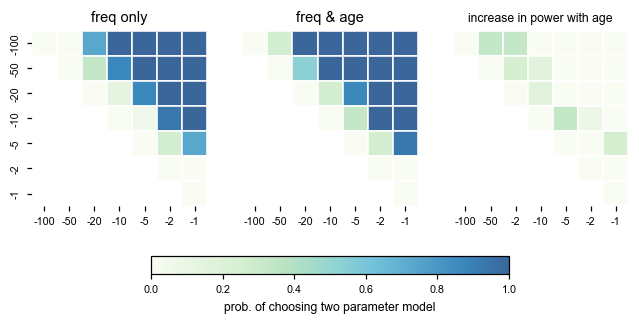

In [20]:
# np.hstack((diffgamma, dubpreds))
# np.argmax(diffgamma[0][1]==np.unique(diffgamma))
plt.figure(dpi=300)
fig, (ax1, ax2, ax3) = plt.subplots(1,3,figsize=(7,4),gridspec_kw={'width_ratios':[1,1.,1.0]})
seaborn.heatmap(powermat_freq.T, mask=mask_pow, xticklabels=[-100,-50,-20,-10,-5,-2,-1], yticklabels=[-100,-50,-20,-10,-5,-2,-1], cmap='GnBu', ax=ax1, cbar=False, linewidths=0.05, square=True,alpha=0.8,vmin=0,); #ax1.set_ylabel(r'$\gamma_1$'); 
ax1.set_title('freq only'); ax2.set_title('freq & age'); ax3.set_title('increase in power with age',fontsize=8)
im = seaborn.heatmap(powermat_age.T, mask=mask_pow, xticklabels=[-100,-50,-20,-10,-5,-2,-1], yticklabels=[], cmap='GnBu', square=True, ax=ax2, linewidths=0.05, vmin=0, cbar=False,alpha=0.8)
seaborn.heatmap(powermat_age.T-powermat_freq.T, mask=mask_pow, xticklabels=[-100,-50,-2,-10,-5,-2,-1], yticklabels=[], cmap='GnBu', vmax=0.8, square=True, ax=ax3, linewidths=0.05, vmin=-0, cbar=False,alpha=0.8)
plt.colorbar(im.get_children()[0], ax = [ax1,ax2,ax3],orientation = 'horizontal',shrink=0.6,label='prob. of choosing two parameter model',)
# plt.savefig('../figs/twoparamdiff.pdf')

In [ ]:
truenumloci = np.zeros(len(gamma))
for ig, g in enumerate(gamma):
    newdf1 = df1.iloc[np.ravel(np.where(dat[:,1]==g)),:]
    sXlred = newdf1['sXl']
    truenumloci[ig] = np.sum((sXlred>10) & (sXlred<n-10+1))

truenumlocifreq = np.zeros(len(gamma))
for ig, g in enumerate(gamma):
    newdf1 = df1.iloc[np.ravel(np.where(dat[:,1]==g)),0:3]
    truenumlocifreq[ig] = newdf1.to_numpy().shape[0]

truenumloci

### Automating workflow for simulating point DFE from PReFerSim (instead of using the R approach from before)

Here, I will write a python function to run the program with appropriate parameters and read the input into a dataframe after.

In [ ]:
os.chdir("/Users/vivaswatshastry/selCoefEst/PReFerSims")
## creating a small set of gamma for simulating data (testing framework) 
## gamma = 4Ns (if it has to coincide with the moments framework)
# gamma = -np.round(np.logspace(0,2,20),2) 
# s = -np.array([1.,5.,10.,50.,100.,500.])
# for ig, g in enumerate(gamma[1:]):
#     with open('simfiles/ParameterFilesConstant.txt',"r") as file:
#         data = file.readlines()

#     data[2] = 'DFEPointSelectionCoefficient: {:f}\n'.format(-0.25*g/10000)
#     data[7] = 'FilePrefix: outfiles/ConstantSize{}\n'.format(-g)

#     with open('simfiles/ParameterFilesConstant.txt', 'w') as file:
#         file.writelines(data)
        
#     os.system("GSL_RNG_SEED={} GSL_RNG_TYPE=mrg ../../PReFerSim/PReFerSim simfiles/ParameterFilesConstant.txt 2".format(rng.integers(100496)))

In [ ]:
## reading in the data and storing in a data frame
nsites = 2000
# gamma = np.array([0, -0.01, -.1, -1, -10, -100])
df1 = pd.DataFrame(index=range(nsites*len(gamma)),columns=['','Xl','s','al','id'])
for ig, g in enumerate(gamma):
    # if(g==-100.):
    #     df1.iloc[(ig*nsites):(ig+1)*nsites] = pd.read_csv('outfiles/ConstantSize50.0.1.full_out.txt'.format(-g),sep='\t',header=None).sample(n=nsites)
    # elif(g==-1.):
    #     df1.iloc[(ig*nsites):(ig+1)*nsites] = pd.read_csv('outfiles/ConstantSize2.0.1.full_out.txt'.format(-g),sep='\t',header=None).sample(n=nsites)
    # else:
    if g!=0:
        df1.iloc[(ig*nsites):(ig+1)*nsites] = pd.read_csv('outfiles/ConstantSize{}.2.full_out.txt'.format(-g),sep='\t',header=None).sample(n=nsites)
    else:
        df1.iloc[(ig*nsites):(ig+1)*nsites] = pd.read_csv('outfiles/ConstantSize{}.2.full_out.txt'.format(g),sep='\t',header=None).sample(n=nsites)
    df1['s'].iloc[(ig*nsites):(ig+1)*nsites] = np.repeat(g,nsites)
df1['empty'] = ''
df1['sXl'] = (df1['Xl']*2000).astype('int')
df1['al'] = 80000+1 - df1['al']
df1['al'] = df1['al'].astype('int')
df1 = df1.iloc[:,1:]
dat = df1.to_numpy()

In [ ]:
for i in range(len(df1)):
    if(df1['al'][i]<0):
        df1.iloc[i,2] = df1.iloc[i,2] + 20000
df1

In [ ]:
# [0.5,1,2,5,10,20,50,100,200,500]
# np.concatenate((-np.arange(1,5),-np.round(np.logspace(-1,10,25,base=2,),1)))
# gamma = -np.logspace(-0.2,3,25,base=10)

In [ ]:
# MutationRate: 1000
# DFEType: point
# DFEPointSelectionCoefficient: 0.005
# DemographicHistory: simfiles/ConstantSize.txt 
# n: 2000
# PrintSegSiteInfo: 1
# LastGenerationAFSamplingValue: 1
# FilePrefix: outfiles/ConstantSize